In [3]:
# set jax backend cpu
import jax
jax.config.update("jax_platform_name", "cpu")

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
from crazymarl.experiments.experiment_loader import Experiment


import asdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_theme(style="white", palette="muted", font_scale=0.8)

import mpl_fontkit as fk
fk.install("Inter")         # downloads Inter from Google Fonts
fk.set_font("Inter") 
# Set the default font size for all plots
plt.rcParams['font.size'] = 10

textwidth = 6.32283  # inches from 455,24411 pt textwidth in the document
# set default figure width to textwidth
plt.rcParams['figure.figsize'] = (textwidth, textwidth * 0.618)  # golden ratio
plt.rcParams['figure.dpi'] = 300  # high-quality output

color_array = sns.color_palette("muted", 10)





one_eight = Experiment('../../../experiments_data/1_quads_figure_eight_20250625_232315/1_quads_figure_eight.crazy.asdf')
two_eight = Experiment('../../../experiments_data/2_quads_figure_eight_20250625_221215/2_quads_figure_eight.crazy.asdf')
three_eight = Experiment('../../../experiments_data/3_quads_figure_eight_20250625_232438/3_quads_figure_eight.crazy.asdf')

one_recovery = Experiment('../../../experiments_data/1_quads_recovery_20250626_155728/1_quads_recovery.crazy.asdf')
two_recovery = Experiment('../../../experiments_data/2_quads_recovery_20250625_234909/2_quads_recovery.crazy.asdf')
three_recovery = Experiment('../../../experiments_data/3_quads_recovery_20250625_235513/3_quads_recovery.crazy.asdf')


Font name: `Inter`
Experiment loaded from ../../../experiments_data/1_quads_figure_eight_20250625_232315/1_quads_figure_eight.crazy.asdf with 1 quads
Experiment loaded from ../../../experiments_data/2_quads_figure_eight_20250625_221215/2_quads_figure_eight.crazy.asdf with 2 quads
Experiment loaded from ../../../experiments_data/3_quads_figure_eight_20250625_232438/3_quads_figure_eight.crazy.asdf with 3 quads
Experiment loaded from ../../../experiments_data/1_quads_recovery_20250626_155728/1_quads_recovery.crazy.asdf with 1 quads
Experiment loaded from ../../../experiments_data/2_quads_recovery_20250625_234909/2_quads_recovery.crazy.asdf with 2 quads
Experiment loaded from ../../../experiments_data/3_quads_recovery_20250625_235513/3_quads_recovery.crazy.asdf with 3 quads


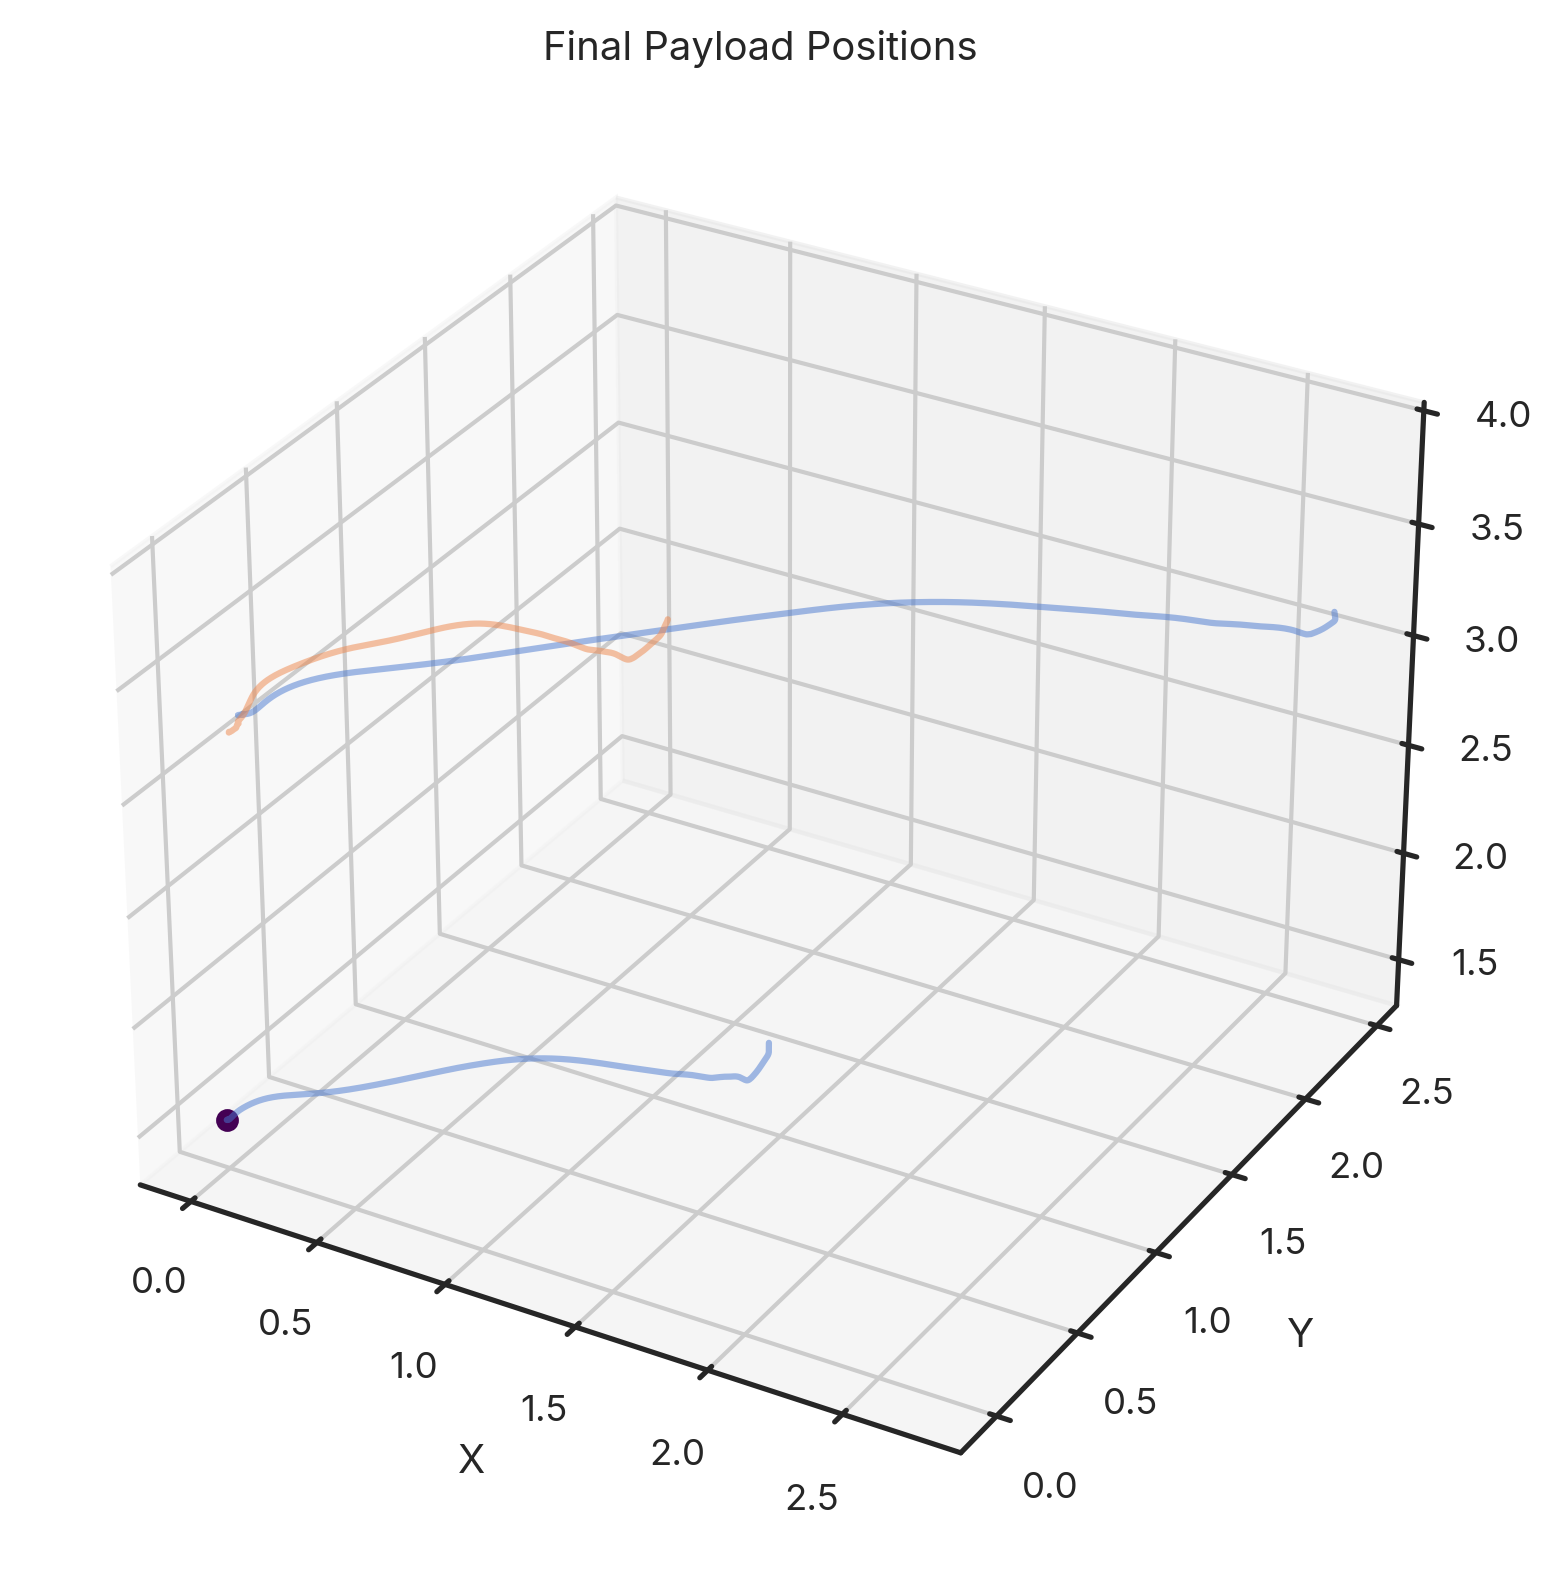

In [34]:
def plot_3d_final_positions(exp: Experiment, runs=None, agent: int = 0, width: float = textwidth):
    """
    Scatter the **final** payload position in 3D for the selected runs.
    runs: int, list of ints, or slice (default -> [0])
    """
    # build a full list of run‐indices
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig = plt.figure(figsize=(width, width))
    ax = fig.add_subplot(111, projection='3d')

    # payload_pos: (T, runs, 3)
    final = exp.payload_pos[-1, run_idxs, :]       # (len(run_idxs), 3)
    xs, ys, zs = final[:, 0], final[:, 1], final[:, 2]
    ax.scatter(xs, ys, zs, c=np.arange(len(run_idxs)), cmap='viridis', depthshade=True)

    # plot full trajectories for those runs that both completed and were selected
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        path = exp.payload_pos[:, idx, :]         # (T, 3)
        ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5)

    # visualize all quads in the same way
    for quad in range(exp.num_quads):
        quad_pos = exp.quad_pos[:, quad, run_idxs, :] + exp.payload_pos[:, run_idxs, :]  # (T, runs, 3)
        for idx in range(len(run_idxs)):
            path = quad_pos[:, idx, :]               # (T, 3)
            ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5, color=color_array[quad % len(color_array)])

    ax.set(xlabel='X', ylabel='Y', zlabel='Z', title='Final Payload Positions')
    return fig
plot_3d_final_positions(two_recovery);


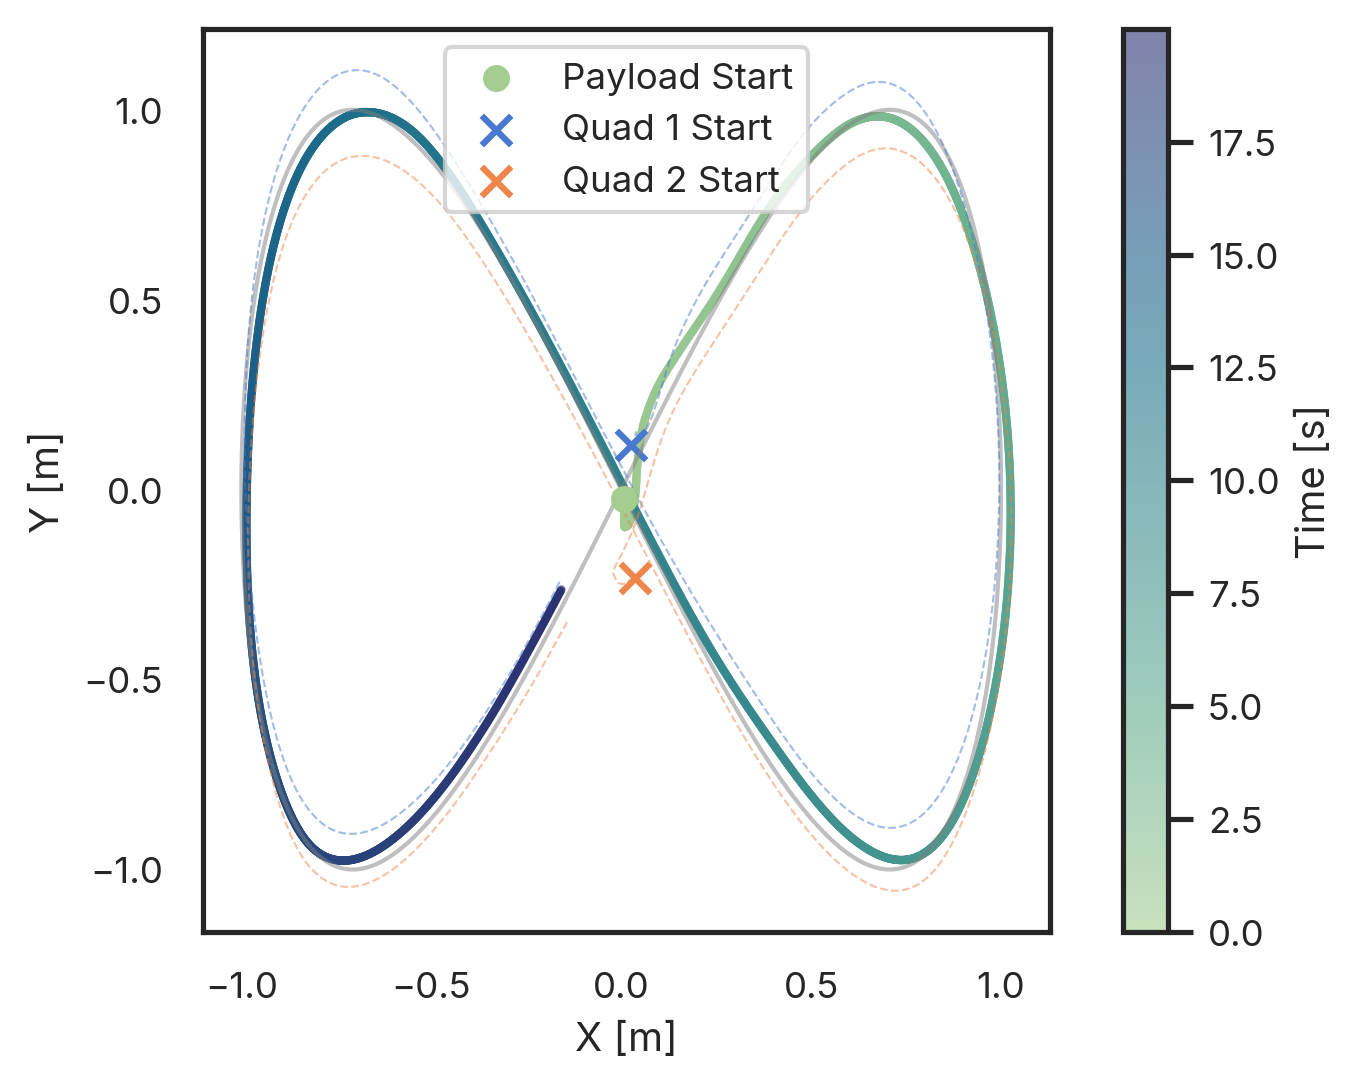

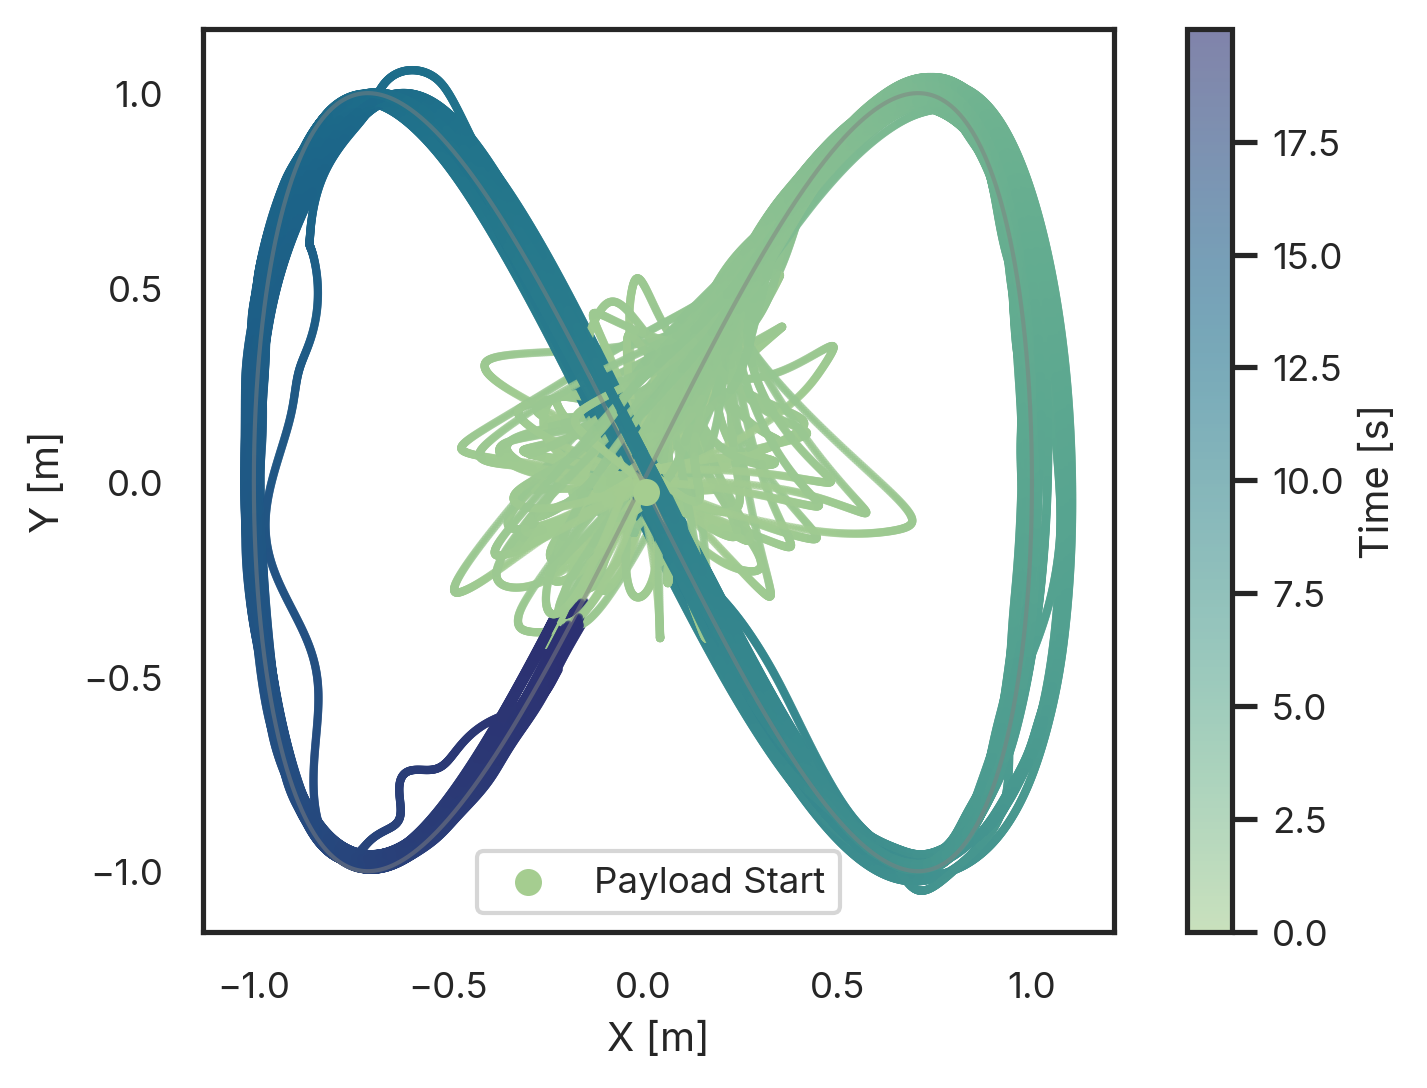

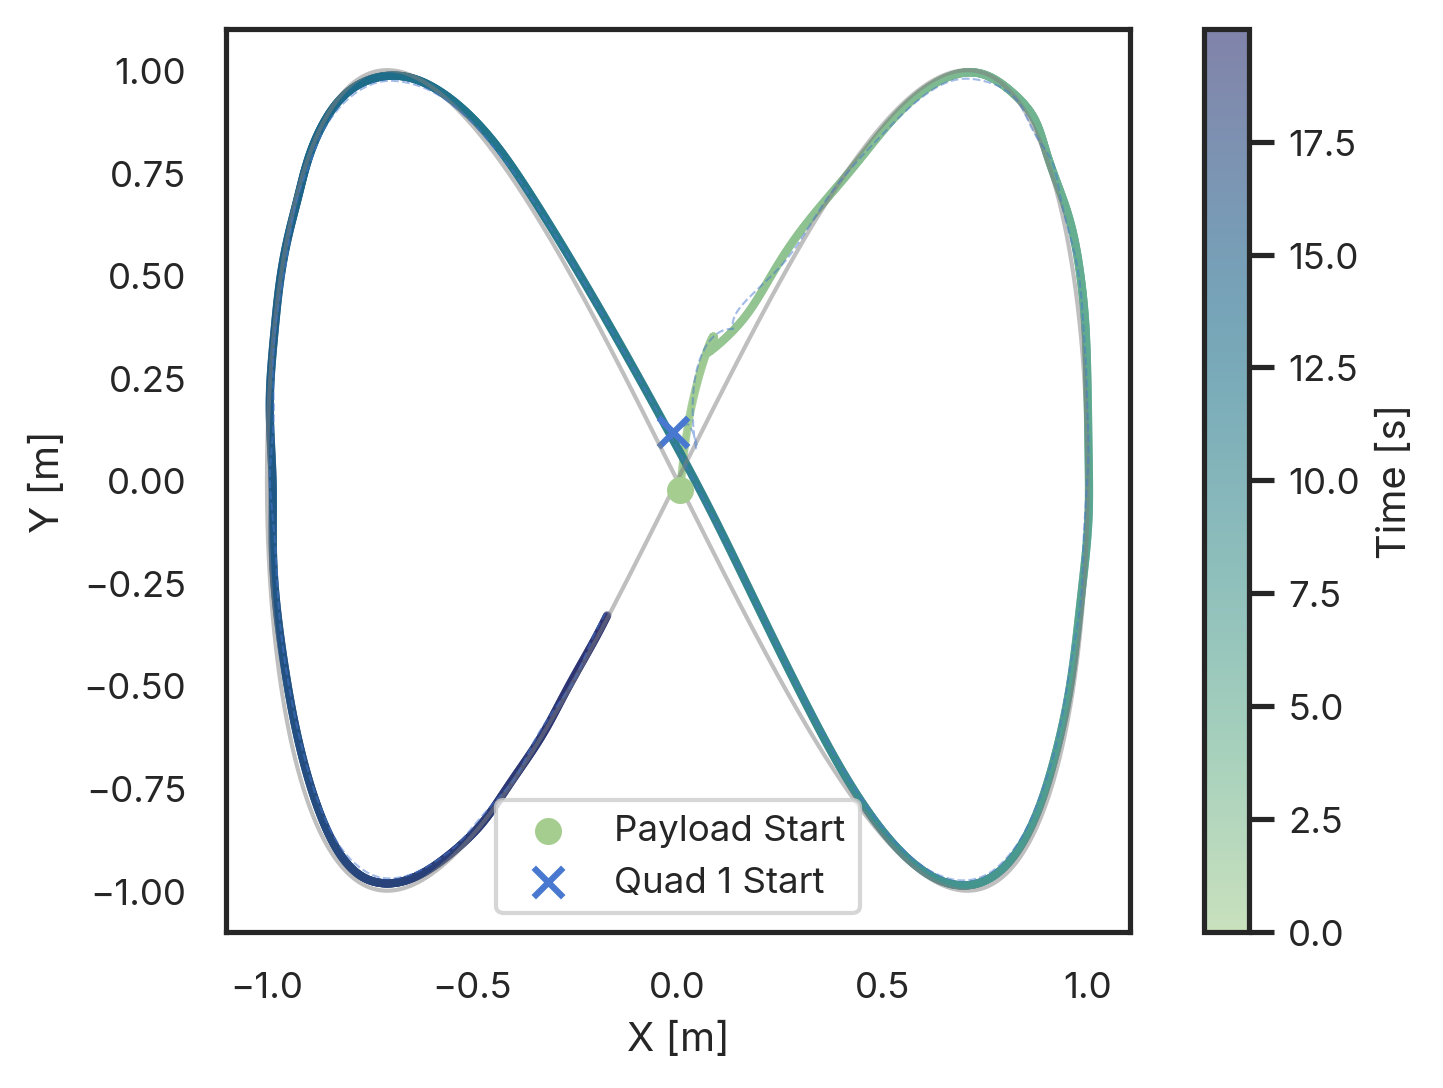

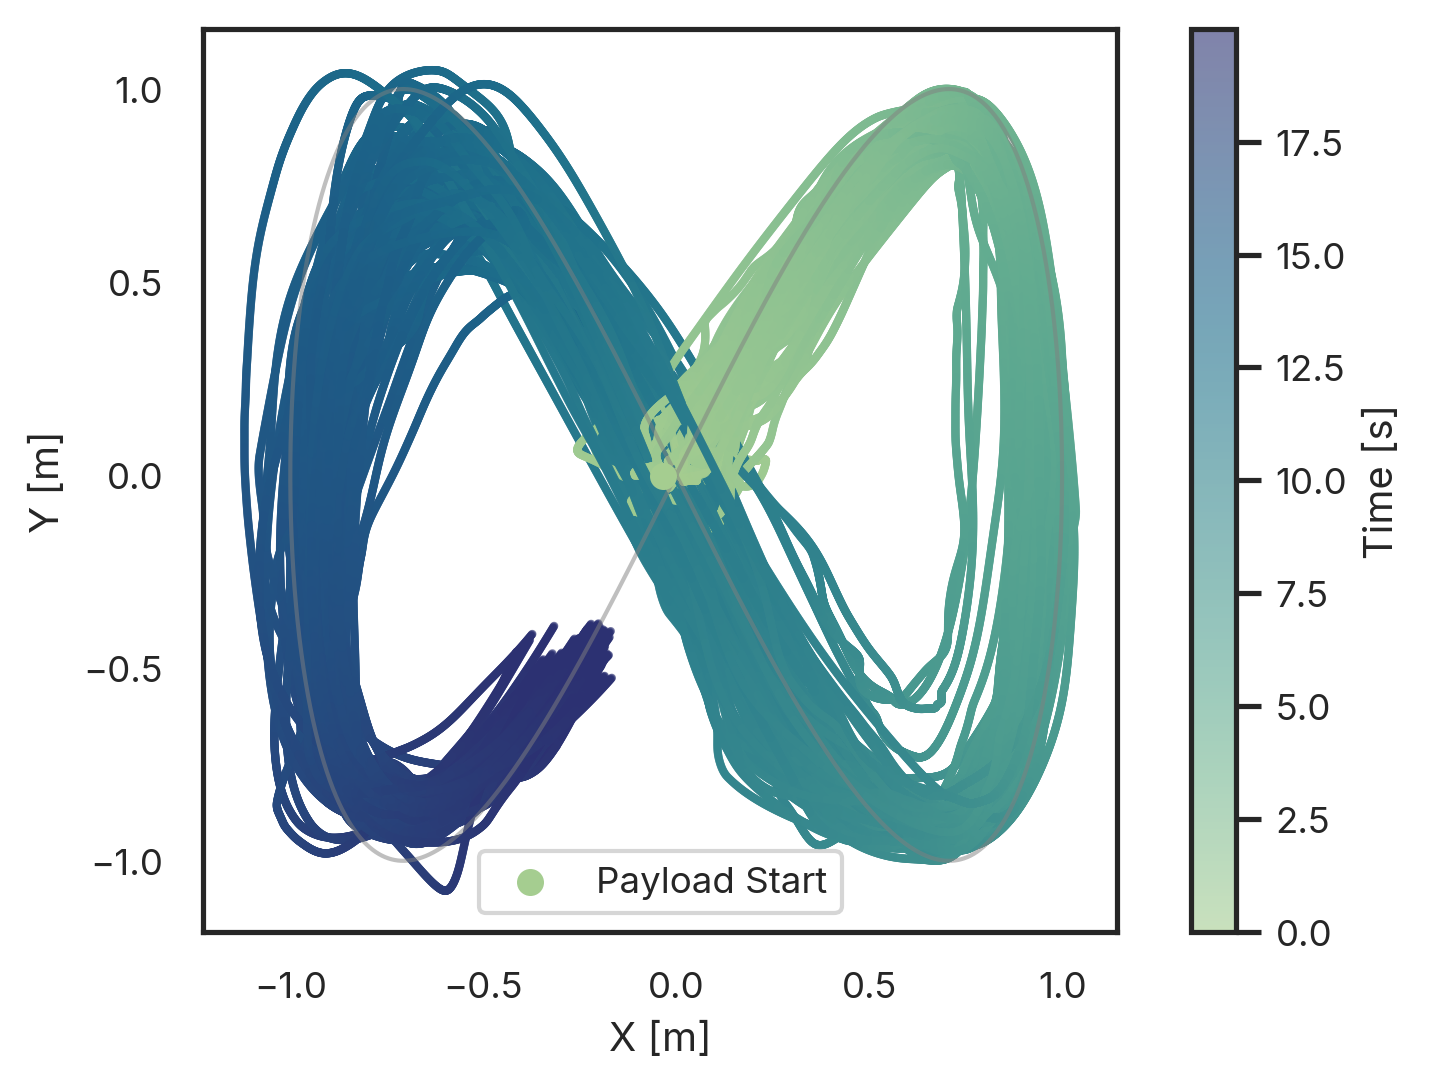

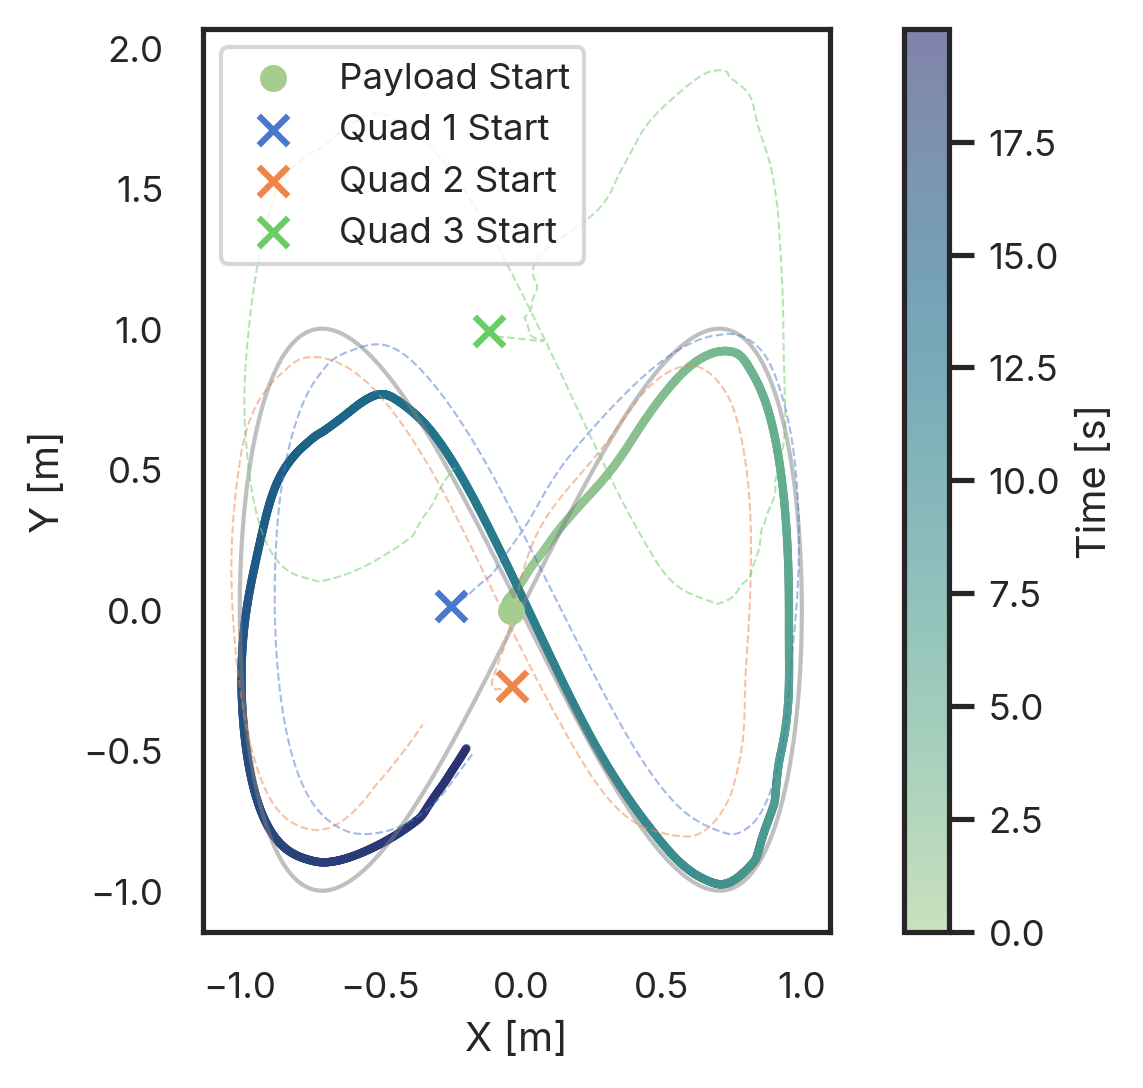

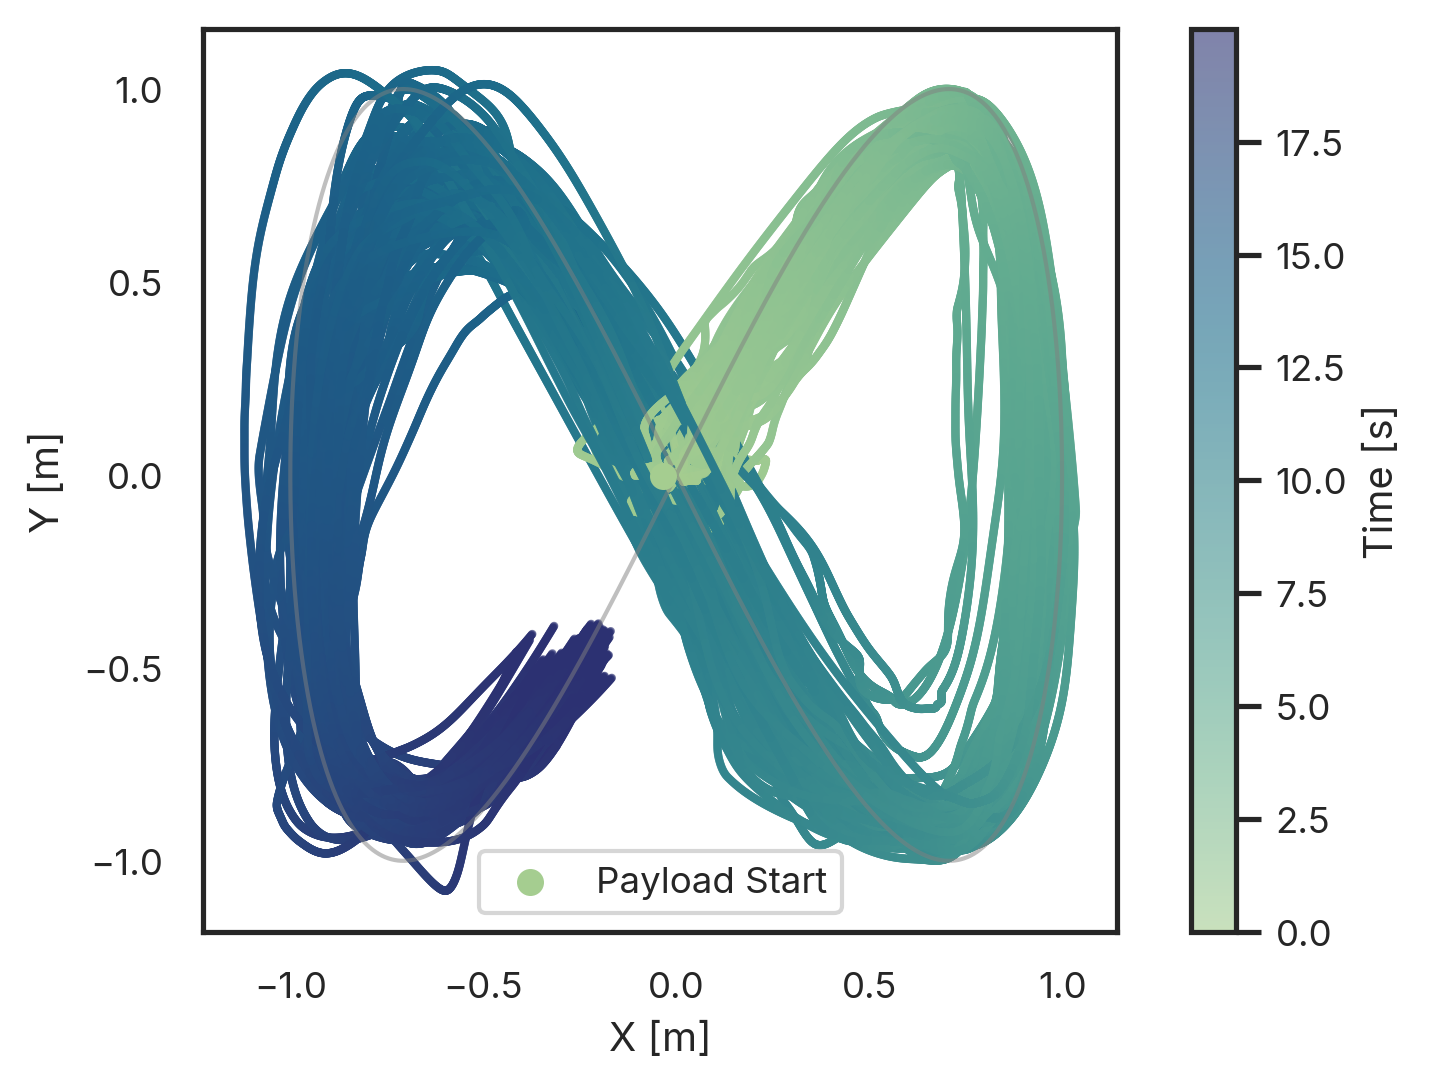

In [35]:

def plot_xy_plane(exp: Experiment, runs=None, width: float = textwidth, show_quads: bool = True):
    """
    Plot payload vs. target in the XY plane.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    # global trajectory: (T, 3)
    traj = exp.trajectory
    if traj is not None and traj.shape and traj.shape[1] == 3:
        ax.plot(traj[:, 0], traj[:, 1], color='gray', alpha=0.5, linewidth=1)
    else: 
        #mark 0,0
        ax.scatter(0, 0, color='gray', alpha=0.5, s=1)

    # scatter each selected-and-completed run
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        rel = exp.payload_pos[:, idx, :]   # (T, 3)
        sc = ax.scatter(rel[:, 0], rel[:, 1], c=exp.time, cmap='crest', s=1, alpha=0.6)

        # get crest first color
        cmap = plt.get_cmap('crest')

        # mark start
        if completed.size:
            start = exp.payload_pos[0, idx, :]
            # add payload start marker only once
            handles, labels = ax.get_legend_handles_labels()
            if 'Payload Start' not in labels:
                ax.scatter(
                    start[0], start[1],
                    s=30,
                    label='Payload Start',
                    marker='o',
                    color=cmap(0.0),
                    zorder=5
                )
            # also show initial quad positions

            if show_quads:

                for q in range(exp.num_quads):
                    path =  exp.payload_pos[:, idx, :2] + exp.own_rel_pos[:, idx, q, :2]
                    ax.plot(path[:, 0], path[:, 1], alpha=0.5, linewidth=0.5, linestyle='--', color=color_array[q])
                    ax.scatter(path[0, 0], path[0, 1], s=50, marker='x', color=color_array[q], label=f'Quad {q+1} Start')


    
    #legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))                # dict keeps first‐seen order
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    ax.set_aspect('equal', 'box')
    fig.colorbar(sc, ax=ax, label='Time [s]')
    ax.set(xlabel='X [m]', ylabel='Y [m]')
    return fig

plot_xy_plane(two_eight);
plot_xy_plane(one_eight, runs=slice(None), show_quads=False);
plot_xy_plane(one_eight);
plot_xy_plane(three_eight, runs=slice(None), show_quads=False);
plot_xy_plane(three_eight);
plot_xy_plane(three_eight, runs=slice(None), show_quads=False);



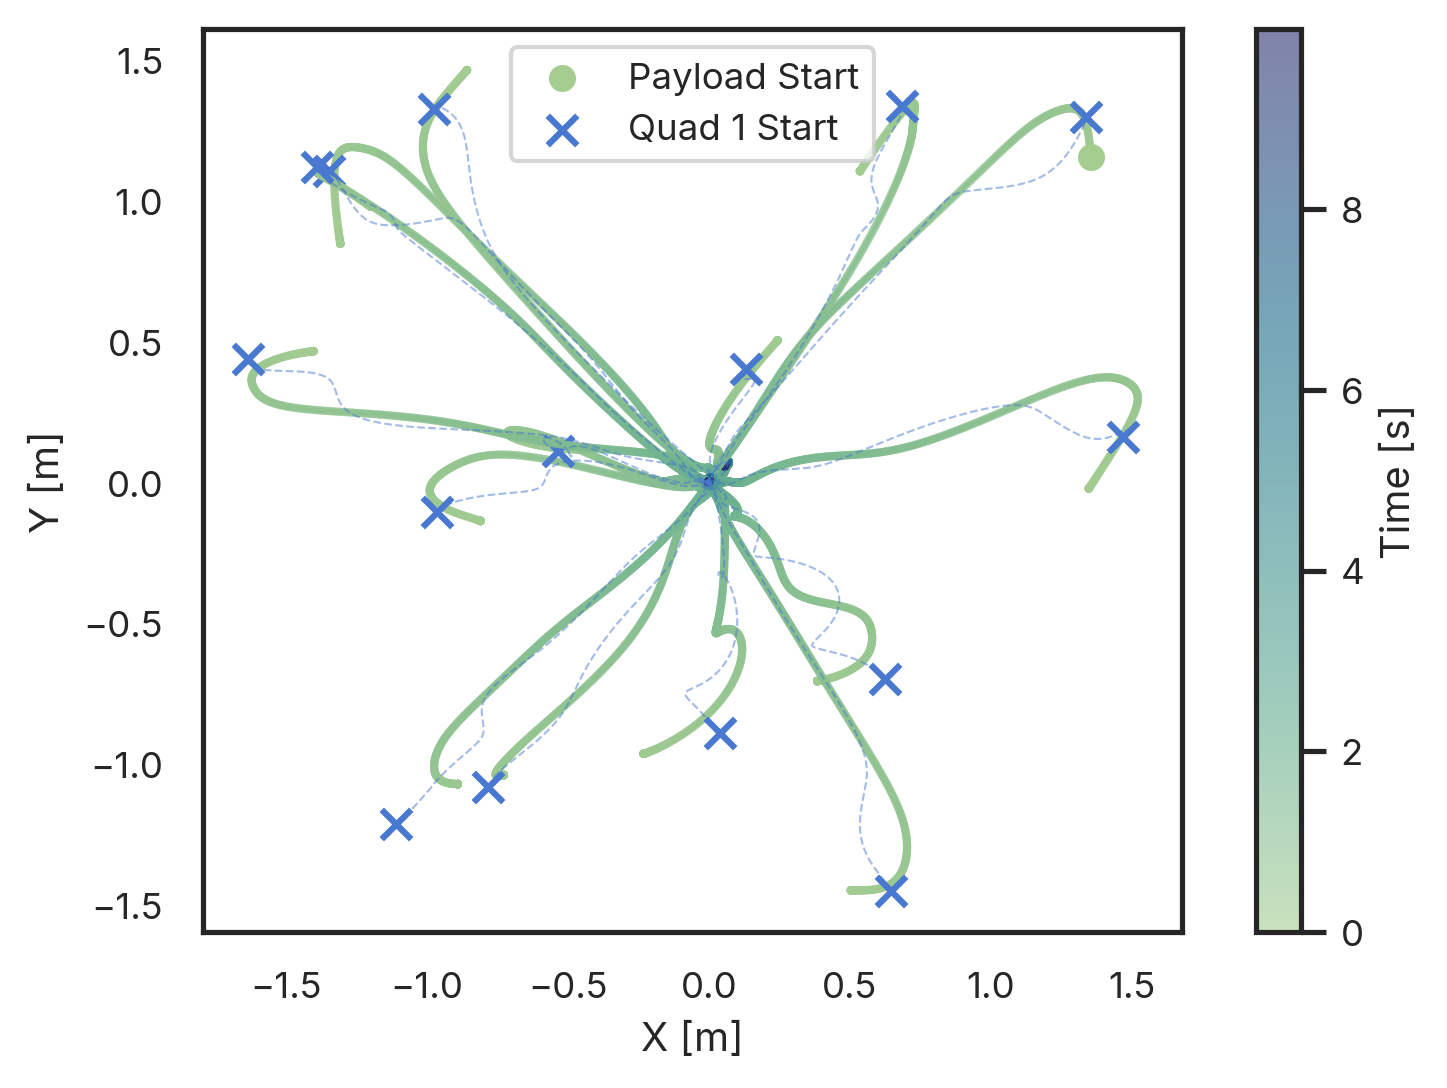

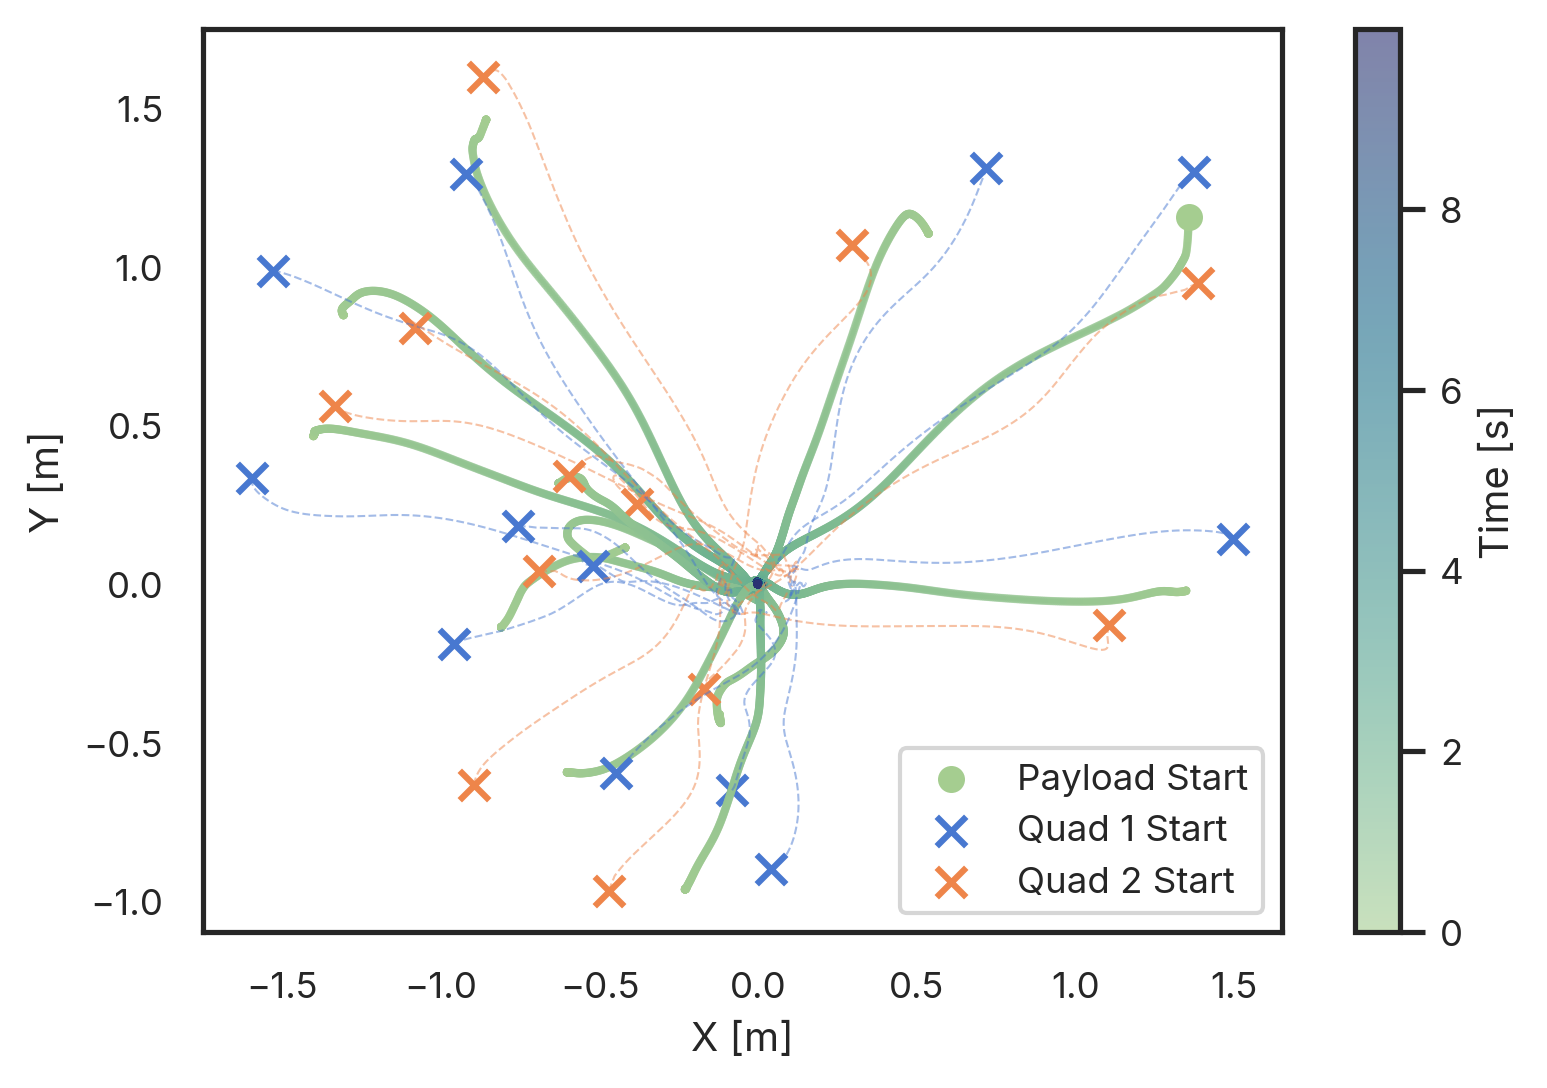

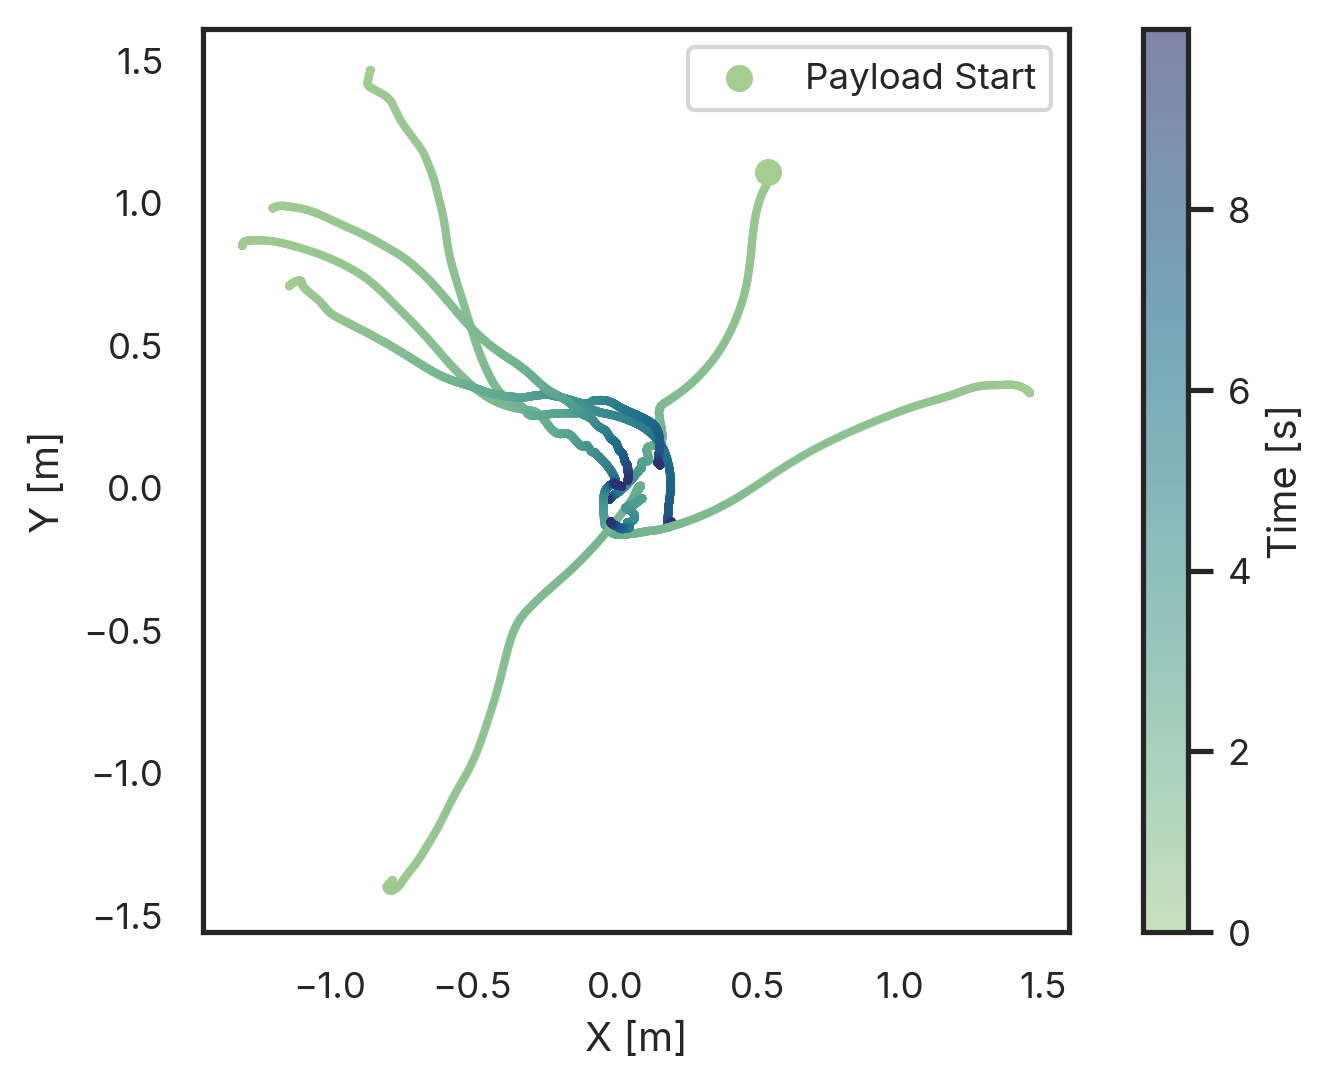

In [36]:
plot_xy_plane(one_recovery, runs=slice(0,15), show_quads=True);
plot_xy_plane(two_recovery, runs=slice(0,15), show_quads=True);
plot_xy_plane(three_recovery, runs=slice(0,15), show_quads=False);


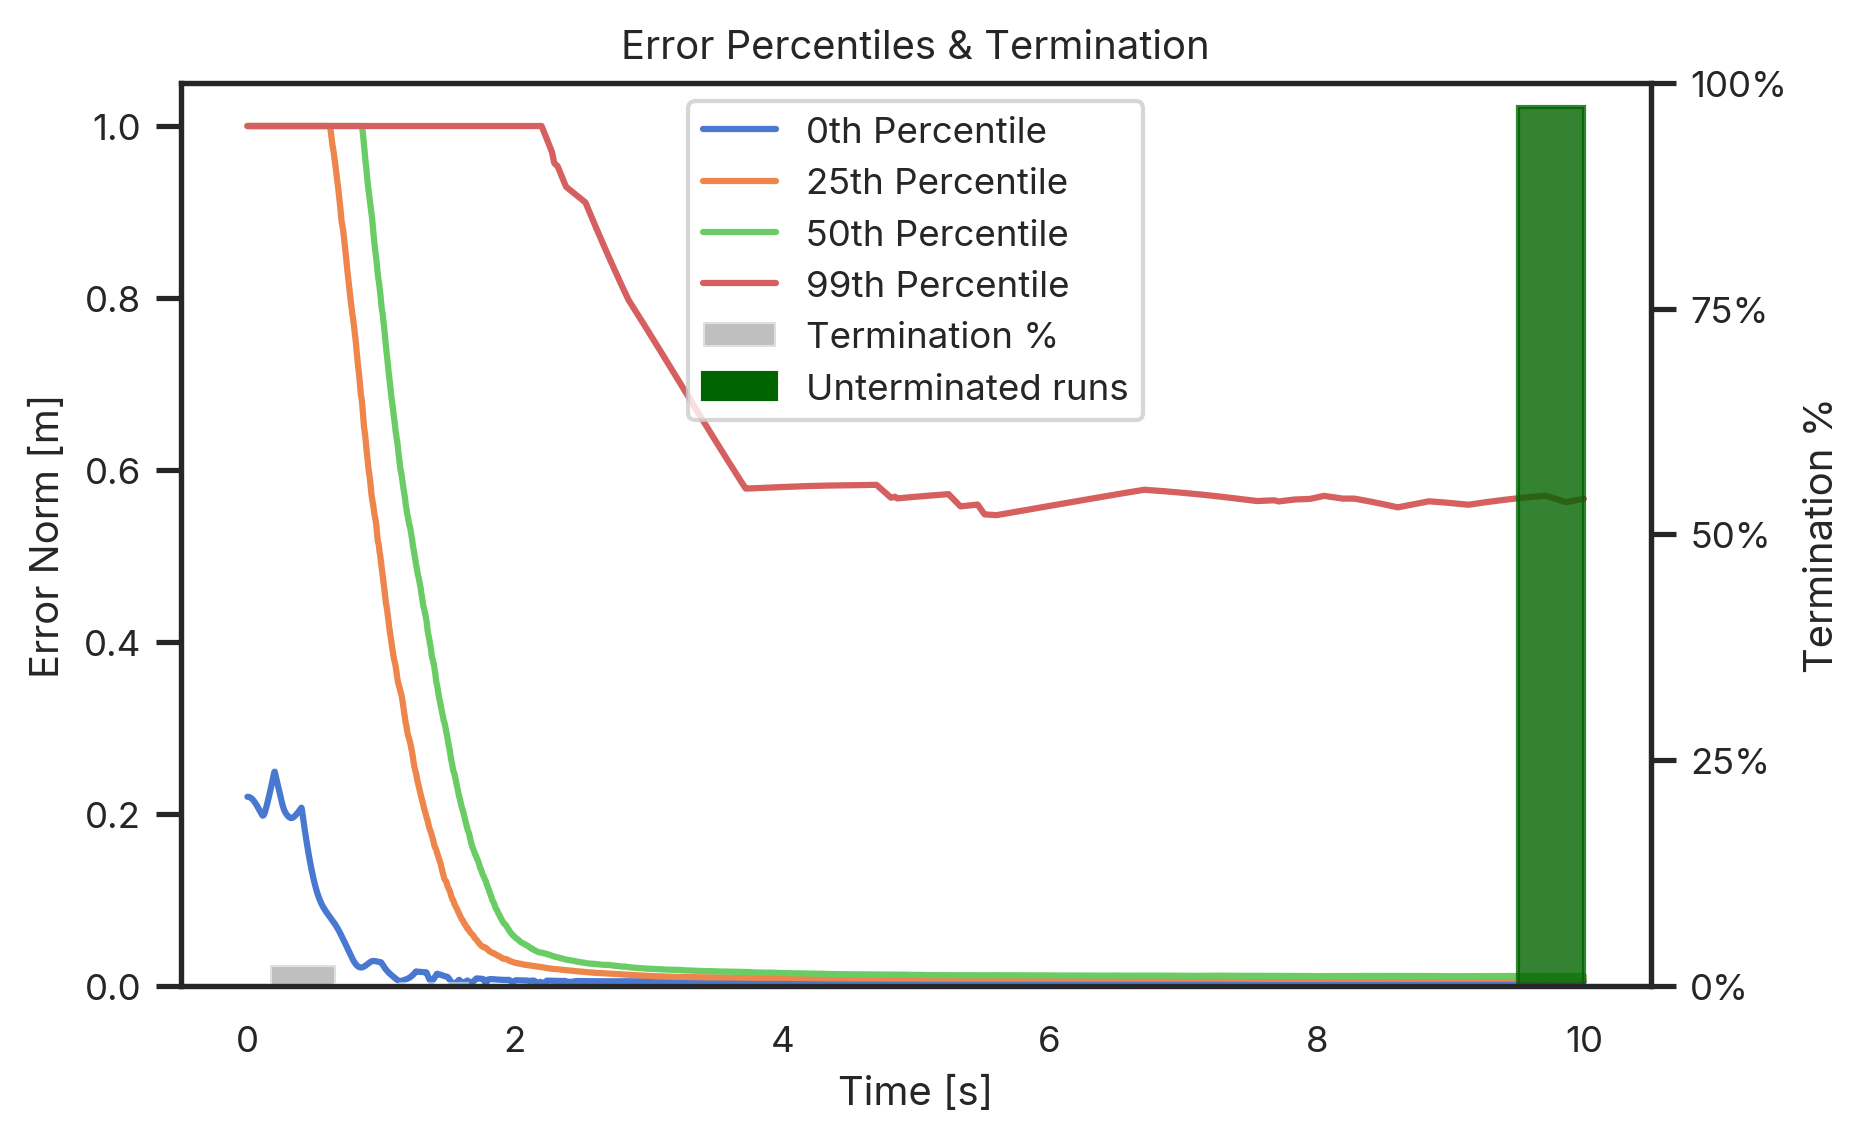

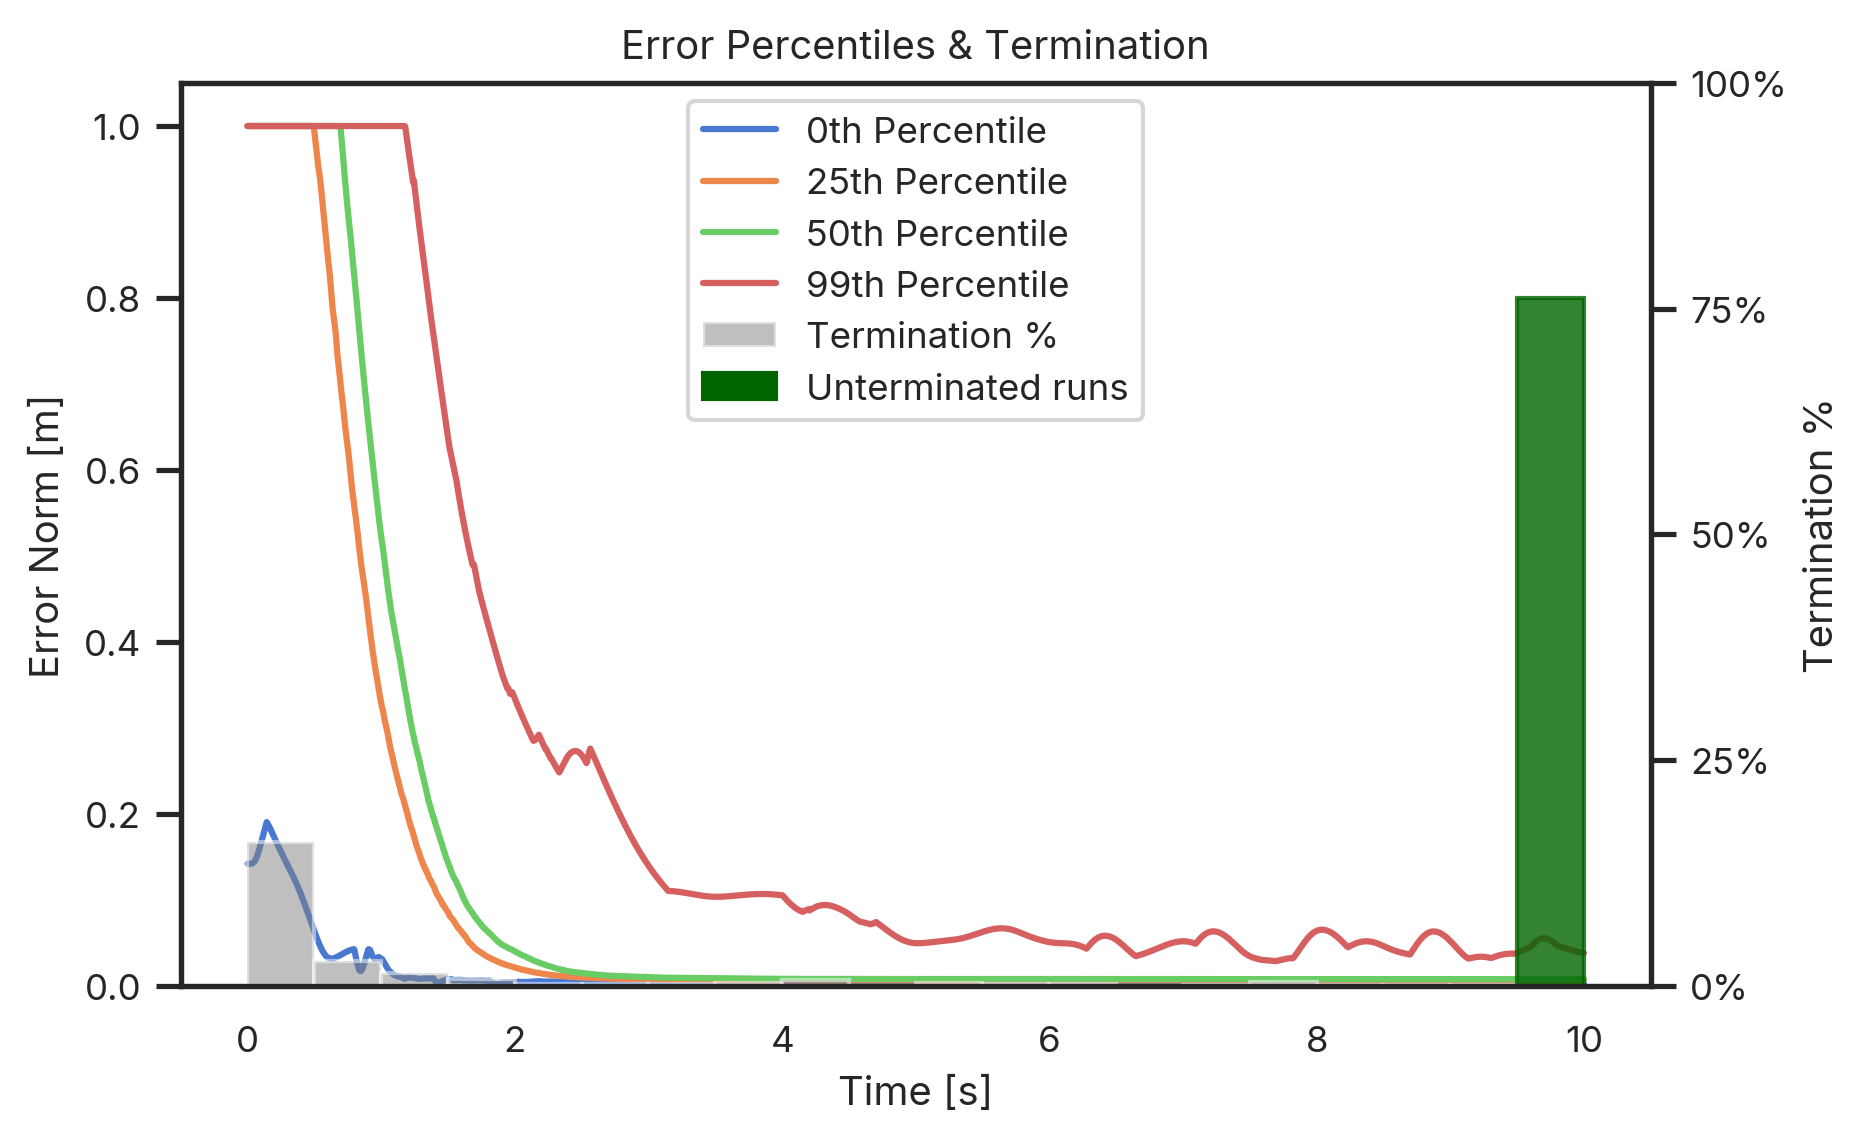

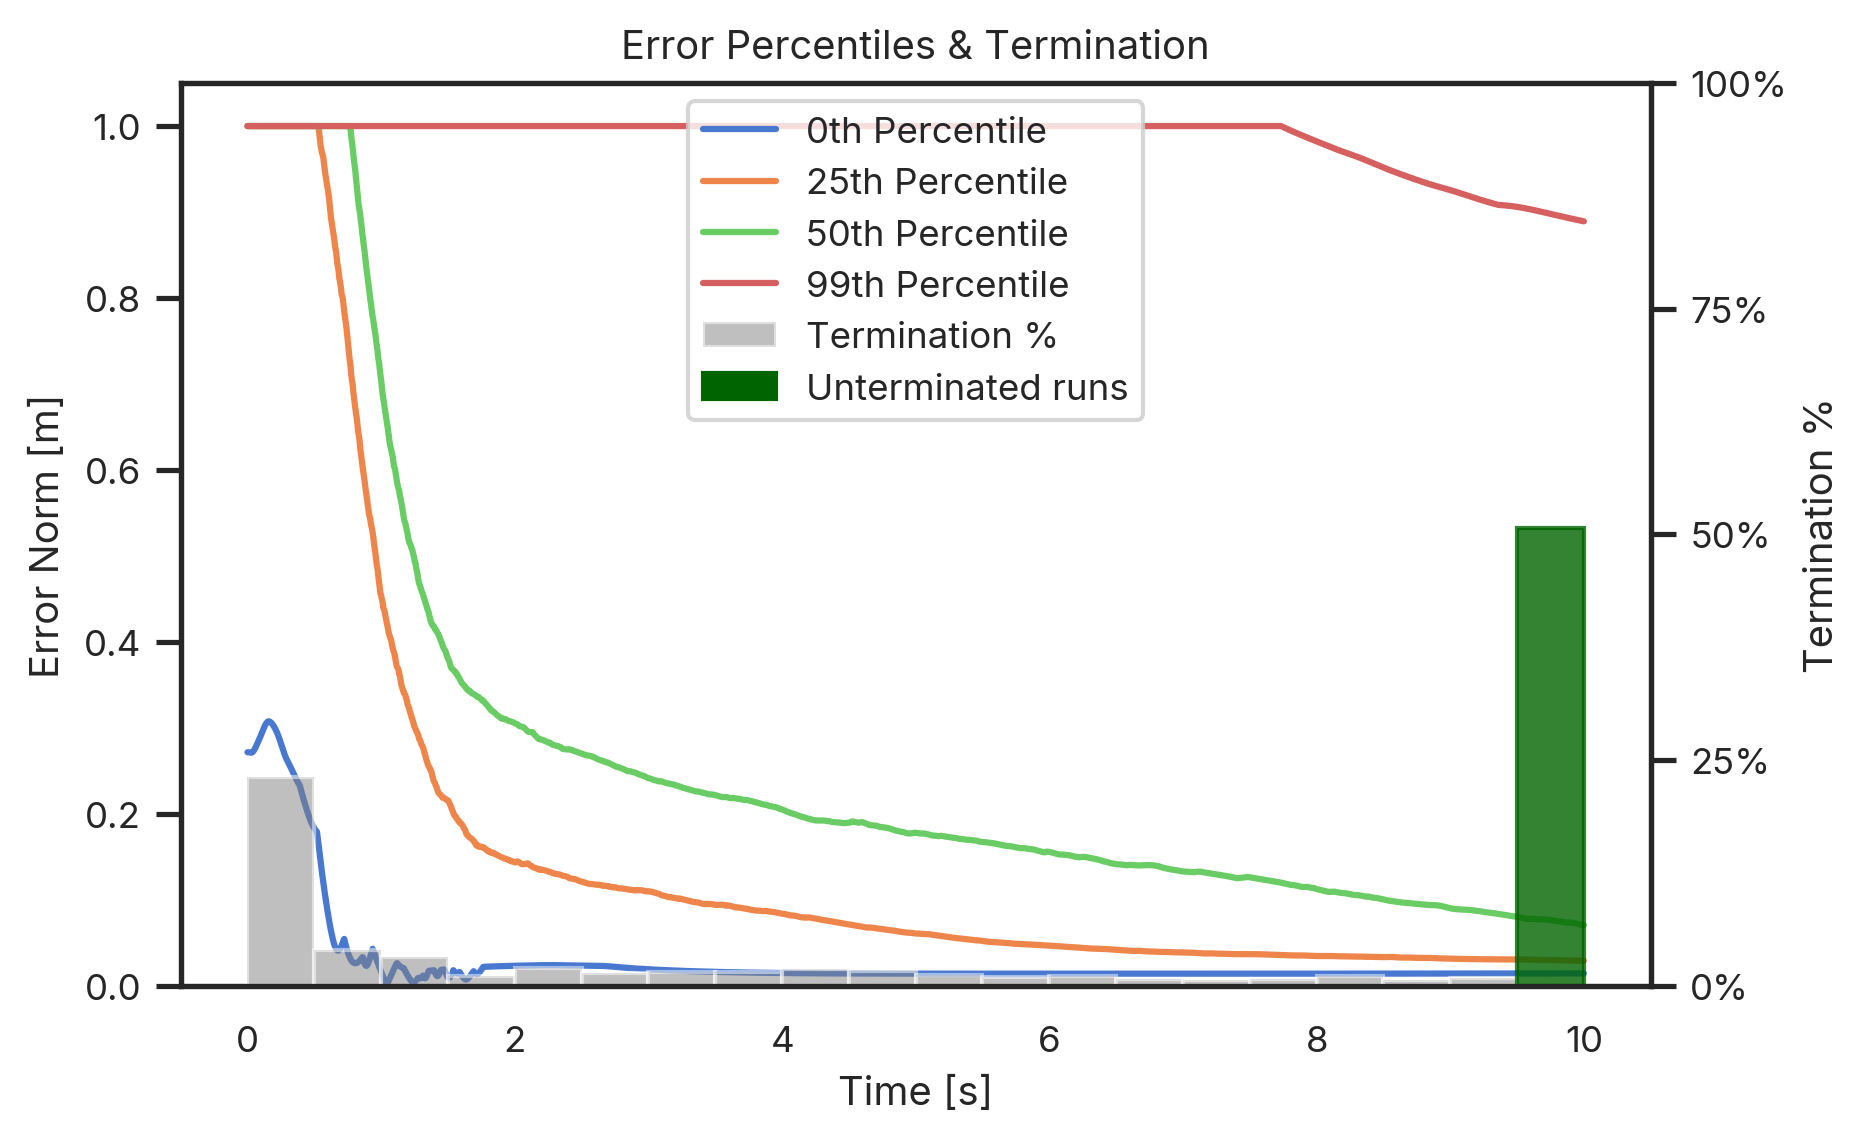

In [37]:
import matplotlib.patches as mpatches
def plot_error_percentiles(exp: Experiment, runs=None, width: float = textwidth):
    """
    Show error-norm percentiles and a histogram of termination times (as %),
    and highlight the last bin as “Unterminated runs”.
    """
    # --- select runs and compute norms ---
    all_runs = np.arange(exp.obs.shape[1])
    run_idxs = all_runs if runs is None else all_runs[runs]

    max_t = exp.payload_error.shape[0]
    norms = np.linalg.norm(exp.payload_error[:max_t, run_idxs, 0, :], axis=-1)

    # --- set up figure & primary axis (percentiles) ---
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in [0, 25, 50, 99]:
        ax.plot(
            exp.time[:max_t],
            np.percentile(norms, p, axis=1),
            label=f'{p}th Percentile',
        )
    ax.set(
        xlabel='Time [s]',
        ylabel='Error Norm [m]',
        title='Error Percentiles & Termination'
    )

    # --- compute termination histogram as percentages ---
    hist, bins = np.histogram(exp.first_dones[run_idxs] * exp.dt, bins=20)
    freq_pct = hist / hist.sum() * 100  # convert to percent
    # set lower y limit to 0
    ax.set_ylim(bottom=0)

    # --- plot bars on the secondary axis ---
    ax2 = ax.twinx()
    bars = ax2.bar(
        bins[:-1],
        freq_pct,
        width=np.diff(bins),
        alpha=0.5,
        color='gray',
        align='edge',
        label='Termination %'
    )
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Termination %')
    pct_ticks = np.linspace(0, 100, 5)
    ax2.set_yticks(pct_ticks)
    ax2.set_yticklabels([f'{int(t)}%' for t in pct_ticks])

    # --- highlight the last bar as "Unterminated runs" ---
    last_bar = bars[-1]
    last_bar.set_color('darkgreen')
    last_bar.set_alpha(0.8)

    # --- combine legends from both axes + highlight patch ---
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    highlight_patch = mpatches.Patch(color='darkgreen', label='Unterminated runs')
    ax.legend(
        handles=h1 + h2 + [highlight_patch],
        labels=l1 + l2 + ['Unterminated runs'],
        loc='upper center',
    )

    return fig

plot_error_percentiles(one_recovery);
plot_error_percentiles(two_recovery);
plot_error_percentiles(three_recovery);

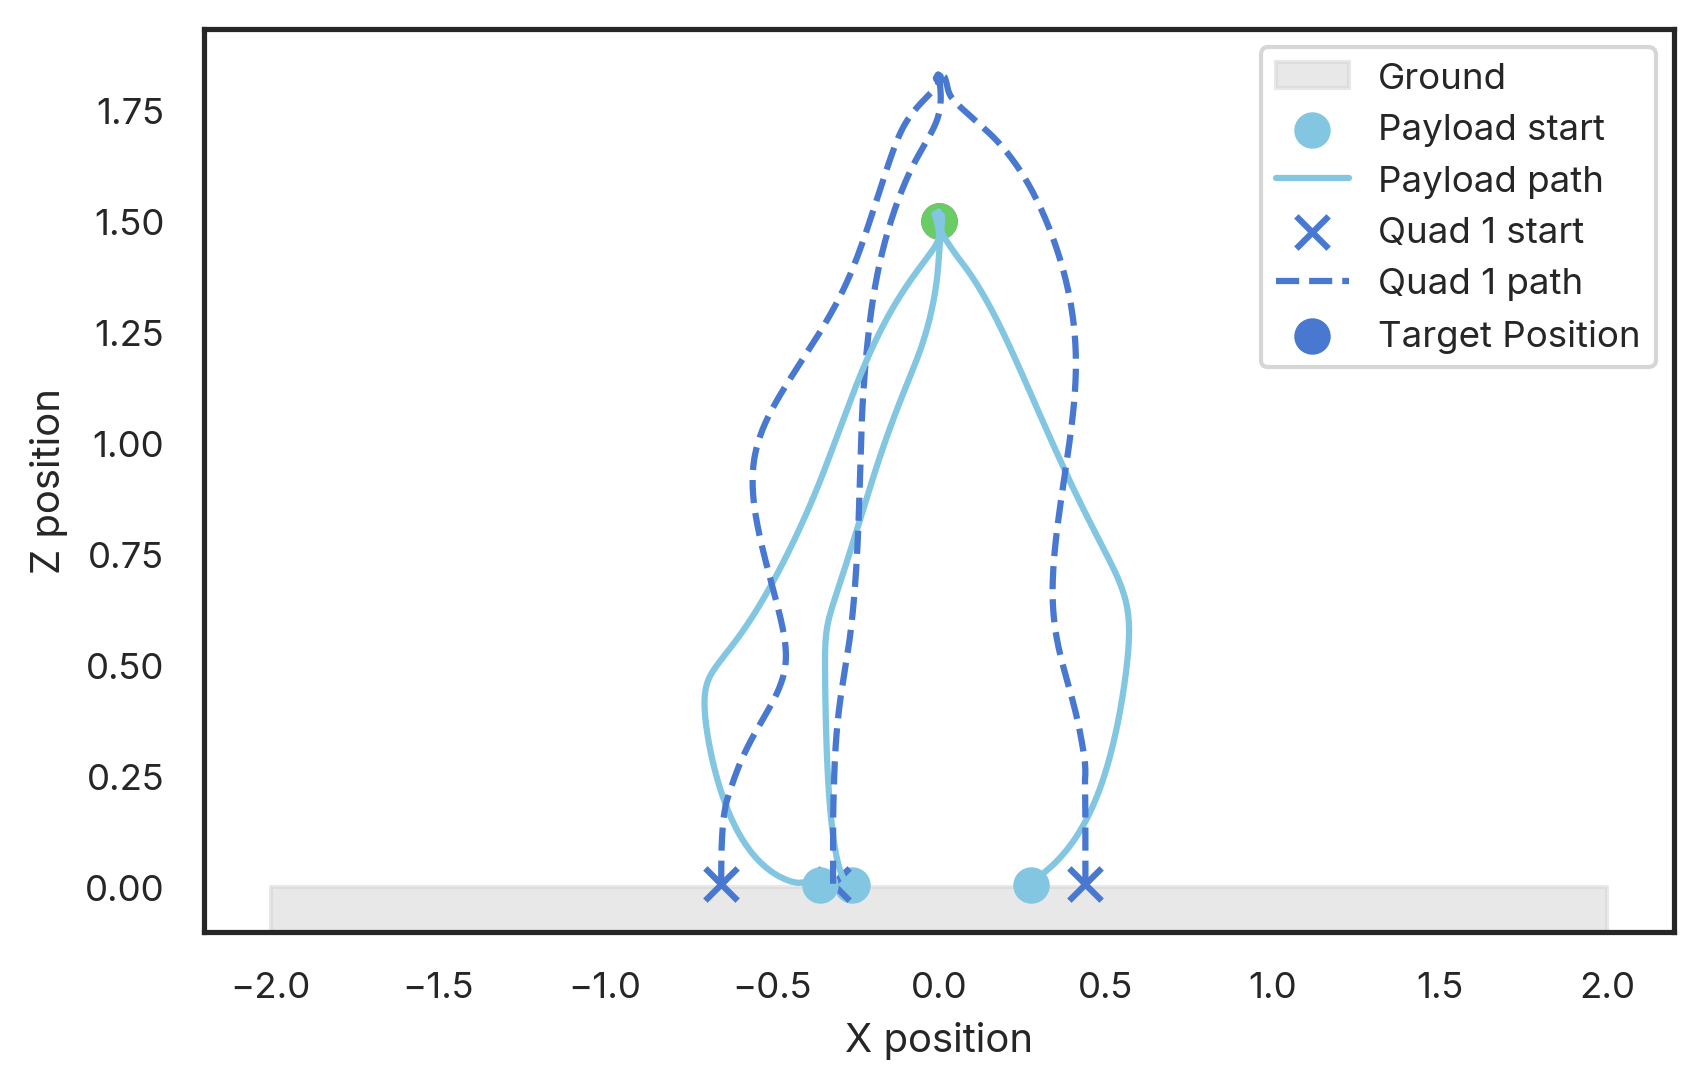

In [38]:
def plot_ground_start_in_xz(exp: Experiment, num_runs=1, width: float = textwidth):
    """
    Plot the payload and quad start positions in the XZ plane (marker),
    then show their full paths over time.
    Now selects runs where the sum of both quads' initial z is the lowest.
    """
    # raw arrays
    payload_pos = exp.payload_pos    # shape: (T, runs,   3)
    quad_pos    = exp.quad_pos       # shape: (T, runs, quads, 3)

    # compute sum of quad z-values at t=0 for each run
    # quad_pos[0, :, :, 2] has shape (runs, quads)
    sum_z0 = quad_pos[0, :, :, 2].sum(axis=1)     # (runs,)

    # get the run-indices sorted by that sum, lowest first
    sorted_runs = np.argsort(sum_z0)
    # pick the first num_runs runs
    selected = sorted_runs[:num_runs]

    # slice down to only those runs
    payload = payload_pos[:, selected, :]        # (T, num_runs, 3)
    quad    = quad_pos[:, selected, :, :]        # (T, num_runs, quads, 3)

    # set up plot
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    # shade “ground” region below z=0
    ax.fill_betweenx([-0.1, 0], -2, 2, color='lightgray', alpha=0.5, label='Ground')

    # loop over each selected run
    for run_idx in range(len(selected)):
        # Payload trajectory
        x_pl = payload[:, run_idx, 0]
        z_pl = payload[:, run_idx, 2]
        ax.scatter(x_pl[0], z_pl[0],
                   s=60, marker='o', color=color_array[9],
                   label='Payload start' if run_idx==0 else "")
        ax.plot(x_pl, z_pl,
                linestyle='-', color=color_array[9],
                label='Payload path'  if run_idx==0 else "")

        # Quad(s) for this run
        n_quads = quad.shape[2]
        for q in range(n_quads):
            x_q = quad[:, run_idx, q, 0]
            z_q = quad[:, run_idx, q, 2]
            ax.scatter(x_q[0], z_q[0],
                       s=60, marker='x', color=color_array[q],
                       label=f'Quad {q+1} start' if run_idx==0 else "")
            ax.plot(x_q, z_q,
                    linestyle='--', color=color_array[q],
                    label=f'Quad {q+1} path'  if run_idx==0 else "")

        # mark target position at (0, 1.5)
        ax.scatter(0, 1.5, s=60, marker='o',
                   label='Target Position' if run_idx==0 else "")

    # avoid duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    ax.set_xlabel('X position')
    ax.set_ylabel('Z position')

    # adjust z‐limits
    z_max = max(payload[:, :, 2].max(), quad[:, :, :, 2].max())
    ax.set_ylim(-0.1, z_max + 0.1)

    return fig
plot_ground_start_in_xz(one_recovery, num_runs=3);

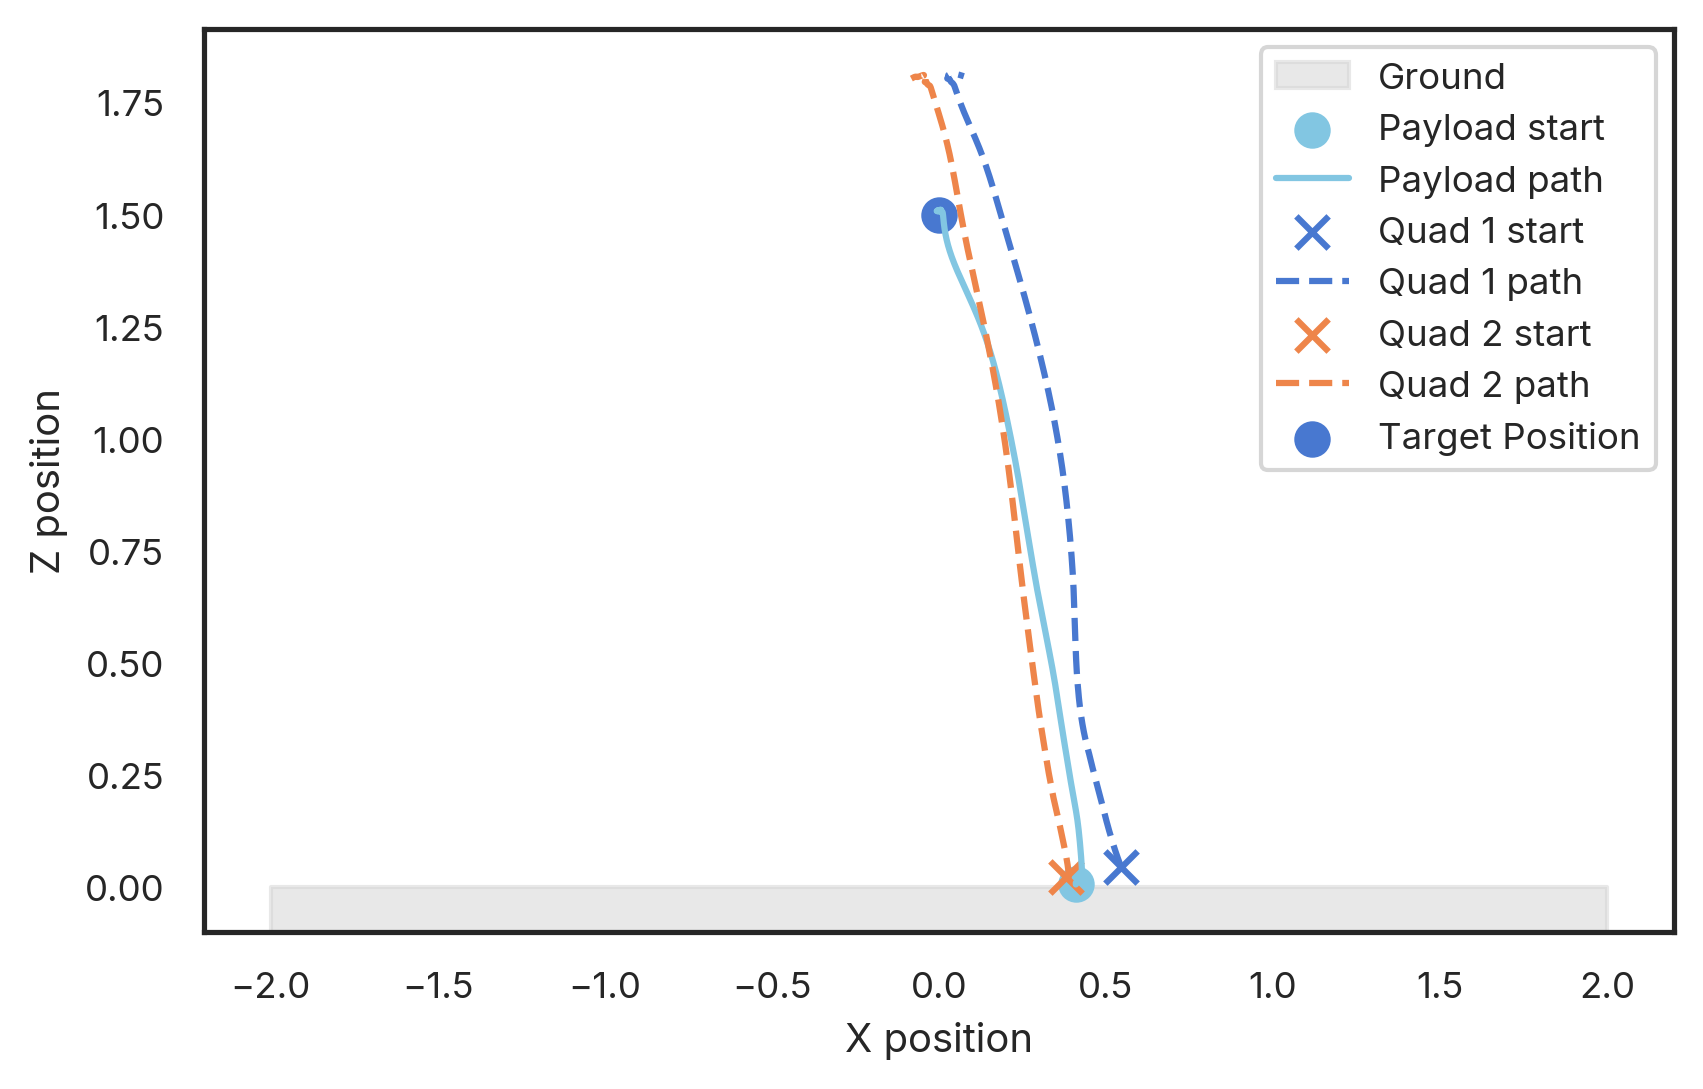

In [39]:
plot_ground_start_in_xz(two_recovery, num_runs=1);

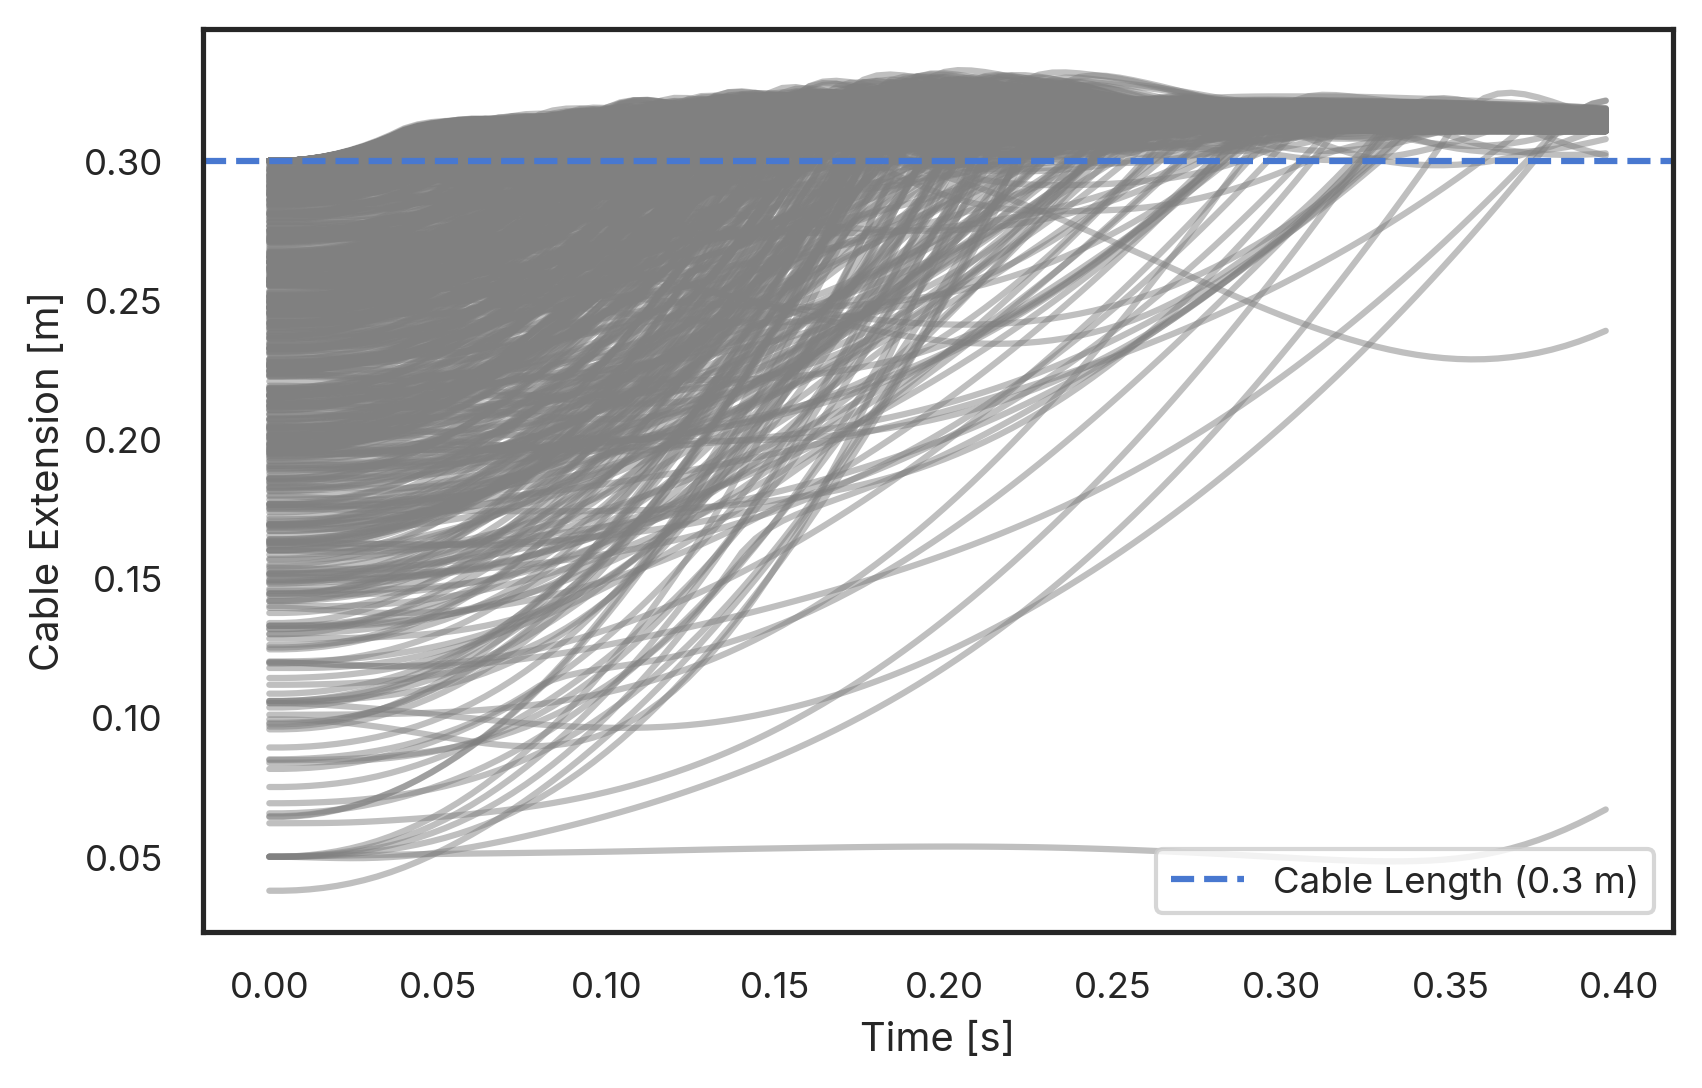

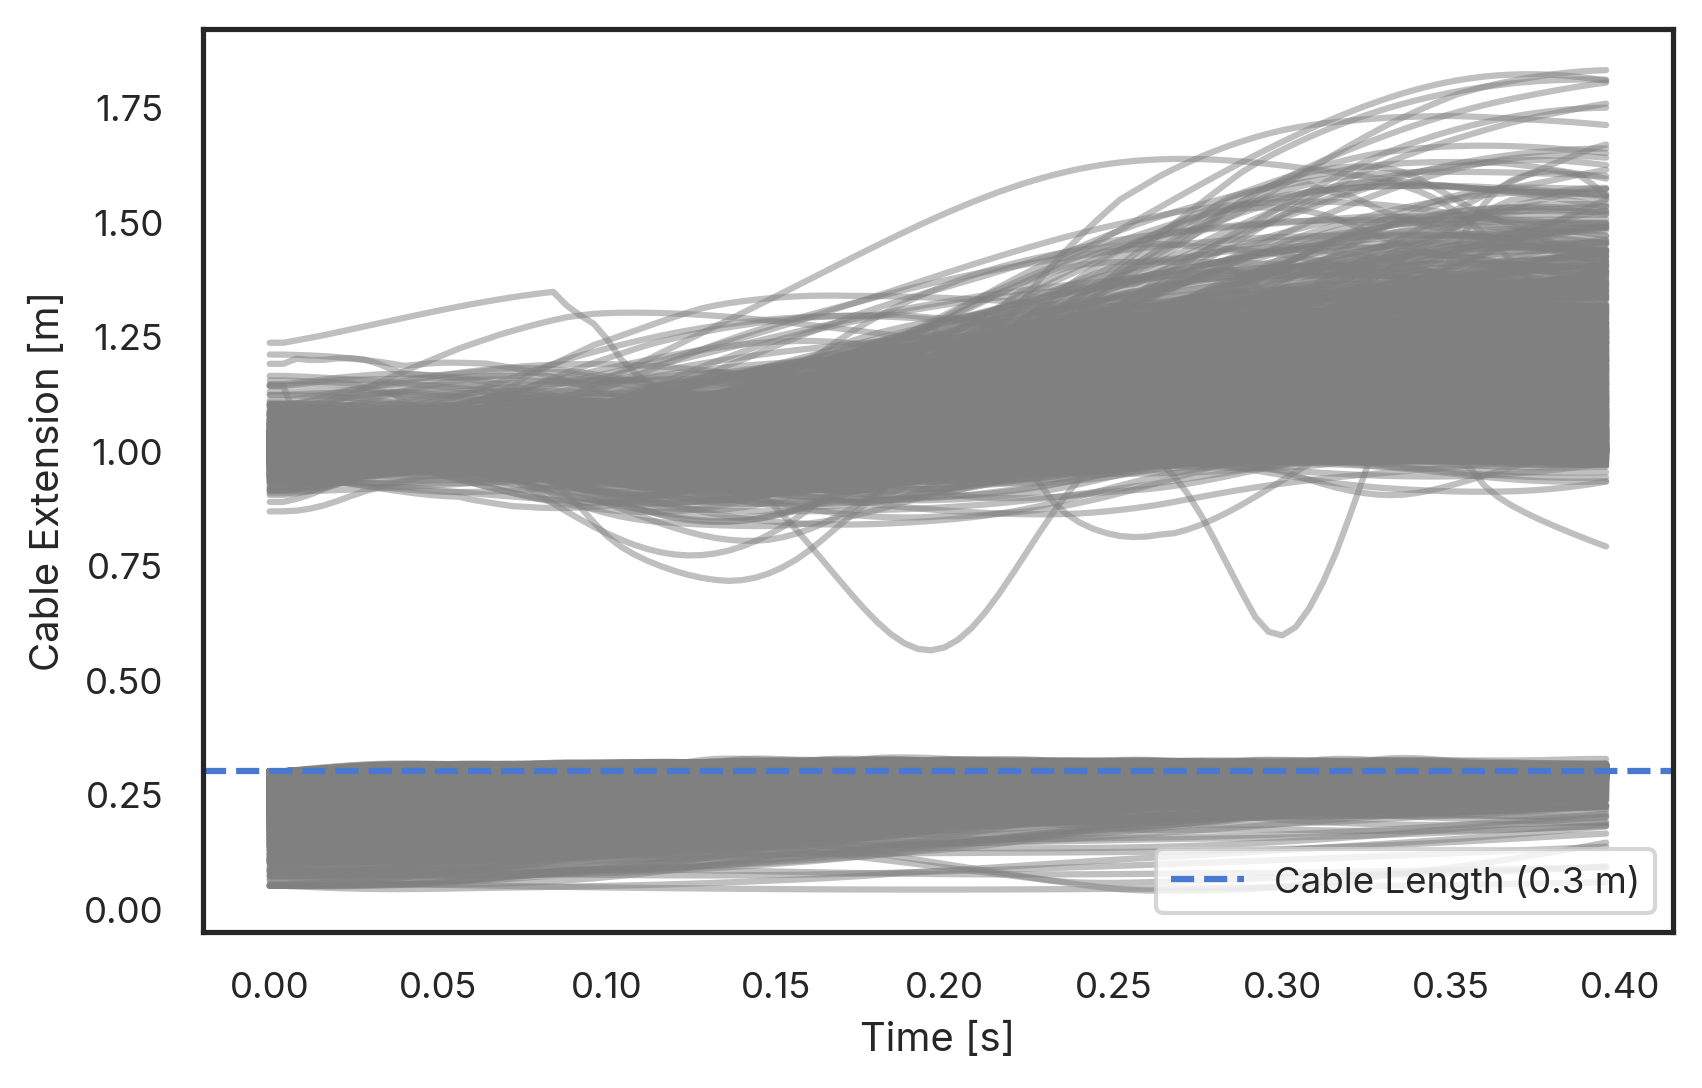

In [51]:
# plot the norm of the quad_rel_pos over time
def plot_quad_rel_pos_norm(exp: Experiment, runs=None, width: float = textwidth
):
    """
    Plot the norm of the quad relative positions over time.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))

    # compute norms for each run
    for idx in run_idxs:
        rel_pos = exp.own_rel_pos[:100, idx, :, :]  # (T, quads, 3)
        norms = np.linalg.norm(rel_pos, axis=-1)  # (T, quads)
        ax.plot(exp.time[:100], norms, color="gray", alpha=0.5)

    ax.set(xlabel='Time [s]', ylabel='Cable Extension [m]')

    # add a dashed line at 0.3 showing cable length
    ax.axhline(y=0.3, linestyle='--', label='Cable Length (0.3 m)')
    ax.legend(loc='lower right')

    return fig
plot_quad_rel_pos_norm(one_recovery, runs=slice(0, 1000));
plot_quad_rel_pos_norm(three_recovery, runs=slice(0, 1000));

(2500, 1000, 1, 4)
(2500, 1000, 2, 4)


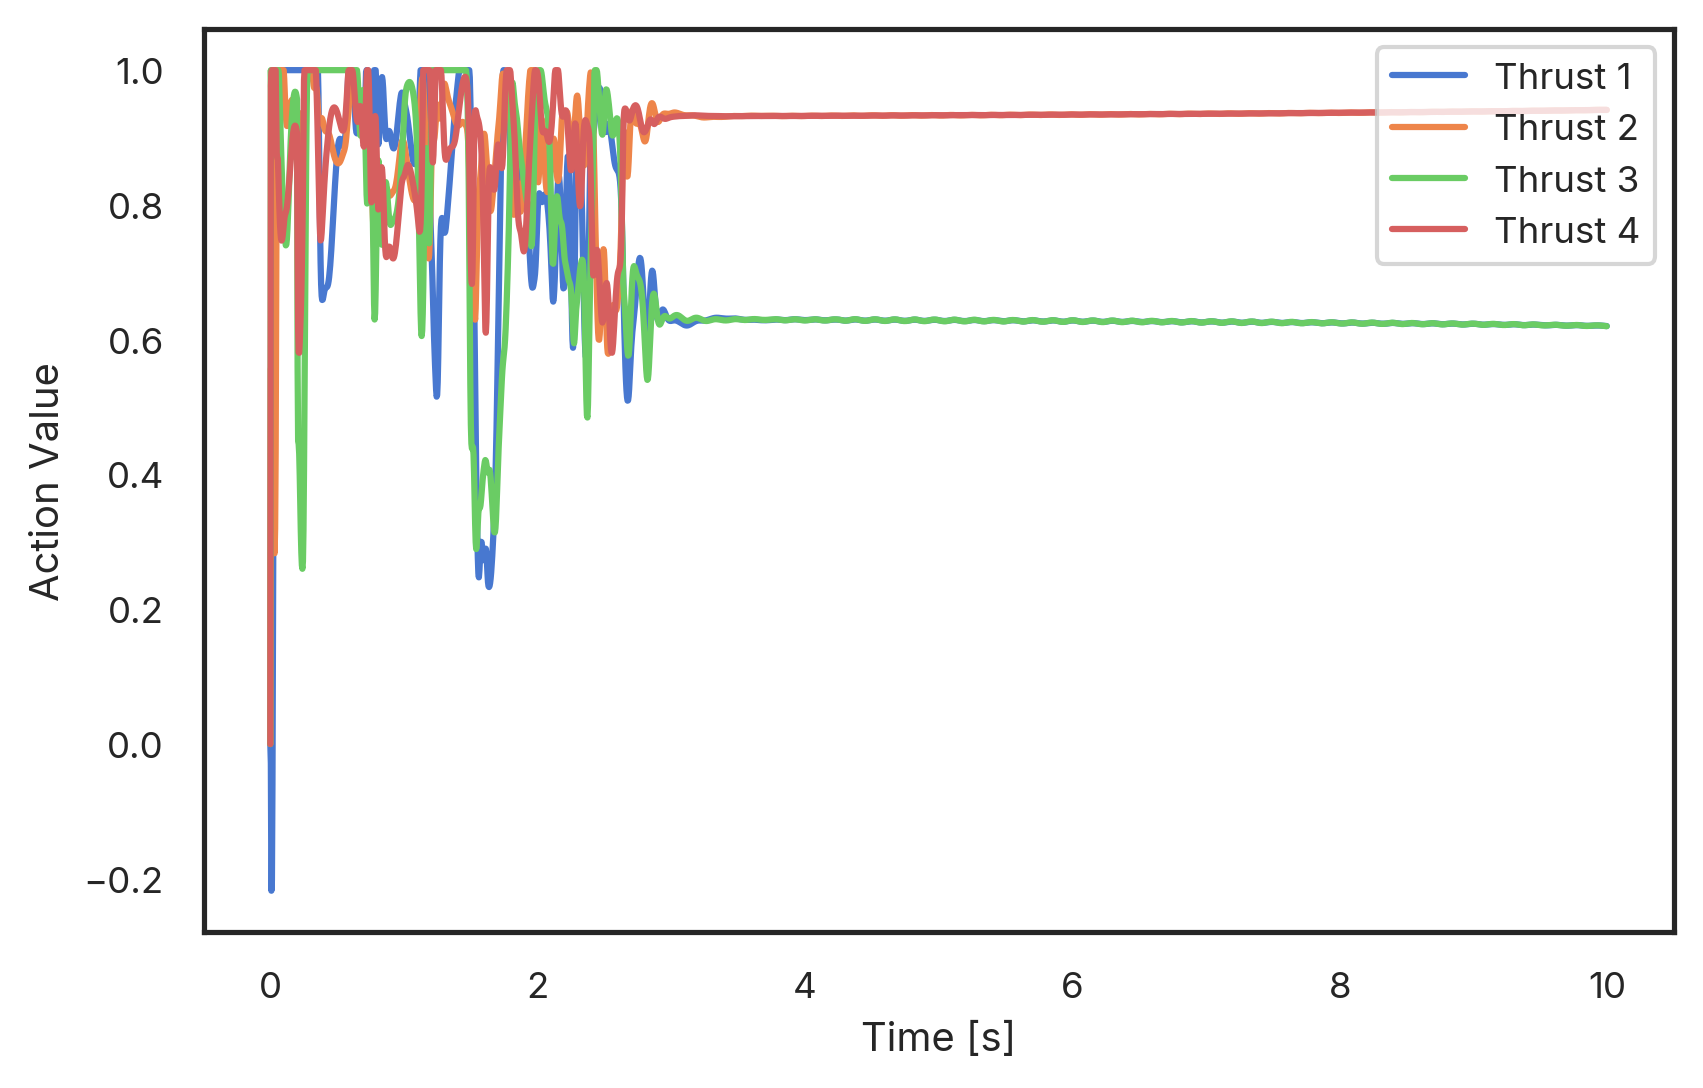

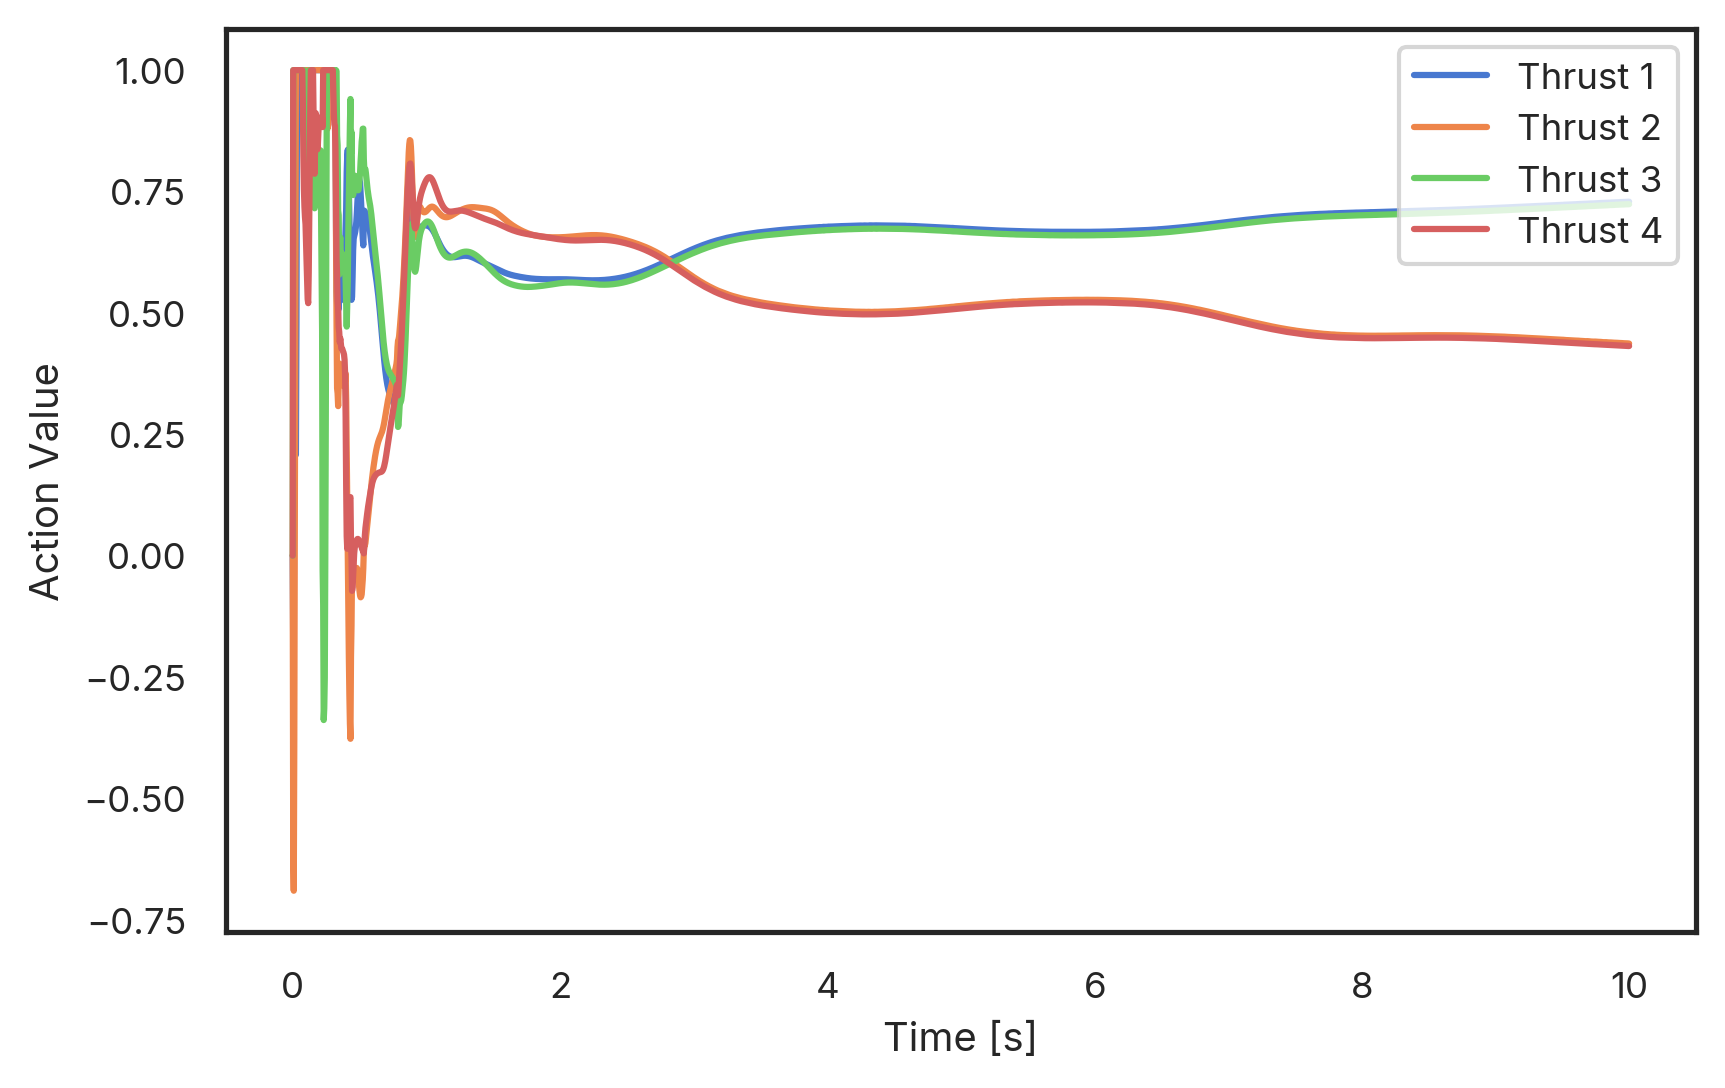

In [4]:
# plot showing the actions over time
def plot_actions(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot the actions over time for the selected runs.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))

    print(exp.own_action.shape)
    actions = exp.own_action[: , 0 , 0 , :]  # (T, runs, quads, 4)
    # plot actions 
    for run_idx in run_idxs:
        ax.plot(exp.time, actions[:, 0], label='Thrust 1', color=color_array[0])
        ax.plot(exp.time, actions[:, 1], label='Thrust 2', color=color_array[1])
        ax.plot(exp.time, actions[:, 2], label='Thrust 3', color=color_array[2])
        ax.plot(exp.time, actions[:, 3], label='Thrust 4', color=color_array[3])


    ax.set(xlabel='Time [s]', ylabel='Action Value')
    ax.legend(loc='upper right')

    return fig
plot_actions(one_recovery, runs=slice(0,1));
plot_actions(two_recovery, runs=slice(0, 1));


In [42]:

def plot_xy_plane(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot payload vs. target in the XY plane.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    # global trajectory: (T, 3)
    traj = exp.trajectory
    ax.plot(traj[:, 0], traj[:, 1], color='gray', alpha=0.5, linewidth=1)

    # scatter each selected-and-completed run
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        rel = traj - exp.payload_pos[:, idx, :]   # (T, 3)
        sc = ax.scatter(rel[:, 0], rel[:, 1], c=exp.time, cmap='crest', s=1, alpha=0.6)

    # mark start
    if completed.size:
        start = traj[0] - exp.payload_pos[0, completed[0], :]
        ax.scatter(start[0], start[1], s=50, label='Start', marker='o')
        # also show initial quad positions
        q0 = start + exp.own_rel_pos[0, completed[0], 0, :]
        others0 = exp.other_rel_pos[0, completed[0], 0, :3]
        ax.scatter(q0[0], q0[1], s=50, marker='x')
        ax.scatter(others0[0], others0[1], s=50, marker='x')
        ax.plot([start[0], q0[0]], [start[1], q0[1]], '--', linewidth=0.5)
        ax.plot([start[0], others0[0]], [start[1], others0[1]], '--', linewidth=0.5)

    ax.set_aspect('equal', 'box')
    fig.colorbar(sc, ax=ax, label='Time [s]')
    ax.set(xlabel='X', ylabel='Y', title='Payload XY Plane')
    return fig


def plot_payload_error_time(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot payload error over time for selected runs.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    # grab the true payload_error: (T, runs, 3)
    pe = exp.get_feature('payload_error', 0)  # not the 4D stacked prop
    t = exp.time

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for i in range(3):
        y = pe[:, run_idxs, i]  # shape (T, len(run_idxs))
        ax.plot(t, y, label=f'Err axis {i}')

    ax.set(xlabel='Time [s]', ylabel='Error', title='Payload Error Over Time')
    ax.legend()
    return fig


def plot_linear_velocity_norm(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot the norm of each quad's linear velocity over time.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    # own_linvel: (T, runs, Q, 3) -> pick quad 0 for example, then norm
    linvel = exp.own_linvel[..., 0, :]        # (T, runs, 3)
    linvel_norm = np.linalg.norm(linvel[:, run_idxs, :], axis=2)  # (T, len(run_idxs))

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for j, r in enumerate(run_idxs):
        end = exp.first_dones[r]
        ax.plot(exp.time[:end], linvel_norm[:end, j], alpha=0.3)

    ax.set(xlabel='Time [s]', ylabel='||LinVel||', title='Linear Velocity Norm')
    return fig


def plot_error_percentiles(exp: Experiment, runs=None, width: float = textwidth):
    """
    Show error-norm percentiles and a histogram of termination times.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    max_t = min(2046, exp.payload_pos.shape[0])
    # use payload_pos for actual error vector
    norms = np.linalg.norm(exp.payload_pos[:max_t, run_idxs, :], axis=2)  # (max_t, len(runs))

    percentiles = [0, 25, 50, 75, 100]
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in percentiles:
        ax.plot(exp.time[:max_t], np.percentile(norms, p, axis=1), label=f'{p}th')

    hist, bins = np.histogram(exp.first_dones[run_idxs] * exp.dt, bins=20)
    ax.bar(bins[:-1], hist / hist.max(), width=np.diff(bins), alpha=0.7)

    ax.set(xlabel='Time [s]', ylabel='Error Norm / Freq', title='Error Percentiles & Termination')
    ax.legend()
    return fig


def plot_avg_payload_speed(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot the average payload speed over time for selected runs.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    # payload_linvel: (T, runs, Q, 3) -> take norm of the payload velocity (replicated over Q)
    vel = exp.payload_linvel[..., 0, :]  # (T, runs, 3)
    speeds = np.linalg.norm(vel[:, run_idxs, :], axis=2)
    avg = speeds.mean(axis=1)

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    ax.plot(exp.time, avg)
    ax.set(xlabel='Time [s]', ylabel='Speed', title='Avg Payload Speed')
    return fig

In [43]:
plot_xy_plane(exp)
plot_payload_error_time(exp)
plot_linear_velocity_norm(exp)
plot_error_percentiles(exp)
plot_avg_payload_speed(exp)
plt.show()

NameError: name 'exp' is not defined

In [ ]:
# Plot initial conditions
experiments_data = [
    '1_quads_recovery_20250619_230918',
    '2_quads_recovery_20250619_231158',
    '3_quads_recovery_20250619_231510']

image_paths = [
    f'../experiments_data/{exp_name}/images/{exp_name[0]}_quads_recovery_first_frame.png'
    for exp_name in experiments_data
]

fig, axs = plt.subplots(2, len(image_paths), figsize=(textwidth, textwidth * 0.618))
fig.tight_layout()

# top row: experiment first frames
for ax, img_path, exp_name in zip(axs[0], image_paths, experiments_data):
    num_quads = exp_name[0]
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'N={num_quads}')

# bottom row: placeholder
placeholder_img = plt.imread('../placeholder_initial.png')
for ax in axs[1]:
    ax.imshow(placeholder_img)
    ax.axis('off')

plt.savefig('plots/initial_conditions.png', bbox_inches='tight', dpi=300)